# Single-cell RNA-seq analysis code for Cell Lines 2 & 3

<b>Table of contents:</b>
 <ol>
  <li><a href=#Setup>Setup</a></li>
  <li><a href=#Load-data>Load data</a></li>
  <li><a href=#Cell-Line-2>Cell Line 2</a></li>
  <ol>
    <li><a href=#CL2-Preprocess-Data>CL2 Preprocess Data</a></li>
    <li><a href=#CL2-Data-overview>CL2 Data overview</a></li>
    <li><a href=#CL2-Double-positive-cells>CL2 Double positive cells</a></li>
    <li><a href=#CL2-DE-analysis>CL2 DE analysis</a></li>
    <li><a href=#CL2-Enrichment-analysis>CL2 Enrichment analysis</a></li>
    <ol>
      <li><a href=#CL2-Crossdisorder>CL2 Crossdisorder</a></li>
      <li><a href=#CL2-Intellectual-Disability>CL2 Intellectual Disability</a></li>
      <li><a href=#CL2-Disgenet>CL2 Disgenet</a></li>
      <li><a href=#CL2-GO-Enrichment>CL2 GO Enrichment</a></li>
      <li><a href=#CL2-Permutation-Tests>CL2 Permutation Tests</a></li>
    </ol>
  </ol>

# Setup

In [2]:
import os
import sys
import csv
import pickle
import itertools
import gzip
import tarfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import scipy.io

import scanpy as sc

/opt/python/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
from rpy2.robjects import pandas2ri
import anndata2ri
import rpy2.robjects as robjects

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/opt/python/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [4]:
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set(style="whitegrid")
sc.settings.verbosity = 3  
sc.settings.n_jobs = 8
sc.settings.set_figure_params(dpi=200, dpi_save=300)

print(sys.version)
sc.logging.print_versions()

3.7.7 (default, Apr 10 2020, 15:22:44) 
[GCC 8.3.0]
scanpy==1.4.6 anndata==0.7.1 umap==0.4.0 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [5]:
%%R
library(scran)
library(MAST)

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [6]:
nacugenes = {
    'Progenitors': 1237,
    'Neuronal': 322,
    'Neuroepithelia': 68
}

In [7]:
def mast_de_groups(adata, groupby, save):
    '''Compute differential expression with the MAST package by treatment covariate within clusters provided as "groupby" and export as excel file'''
    
    # Define R function to run MAST analysis
    robjects.r('''
        mast_de_r <- function(data_mat, obs, var, clusters, groupby){
            #Prepare data sets for SingleCellExperiment data structure conversion
            obs['wellKey'] = row.names(obs)
            var['primerid'] = row.names(var)

            #Convert to SingleCellExperiment type
            sca <- FromMatrix(exprsArray=data_mat, cData=obs, fData=var)

            #Compute Gene detection rate
            cdr <- colSums(assay(sca)>0)
            colData(sca)$ngeneson = scale(cdr)

            #Create a vector that will hold all the DE results
            output <- vector("list", length(clusters))

            count <- 0

            #Loop over all louvain clusters
            for (i in clusters){
                count <- count+1
                
                #Create data subsets which should be used for testing
                sca_sub <- subset(sca, with(colData(sca), louvain_three==i))


                #Filter out non-expressed genes in the subset
                sca_sub <- sca_sub[rowSums(assay(sca_sub)) != 0, ]

                #Define & run hurdle model
                zlmCond <- zlm(formula = ~treatment + ngeneson, sca=sca_sub)
                summaryCond <- summary(zlmCond, doLRT='treatmentVeh')

                summaryDt <- summaryCond$datatable

                result <- merge(summaryDt[contrast=='treatmentVeh' & component=='H',.(primerid, `Pr(>Chisq)`)], #p-vals
                                 summaryDt[contrast=='treatmentVeh' & component=='logFC', .(primerid, coef)], #logFC coefficients
                                 by='primerid') 

                #Correct for multiple testing (FDR correction) and filtering
                result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
                result[,coef:=result[,coef]/log(2)]
                names(result) <- c("gene", "pval", "log2FC", "qval")
                result = result[order(result$qval),]

                output[[count]] <- result

            }
            return(output)
        }
    ''')
    
    mast_de = robjects.globalenv['mast_de_r']
    

    data_mat = adata.X.A.T
    obs = adata.obs
    var = adata.var
    clusters = list(adata.obs[groupby].cat.categories)
    
    expr_dict = {adata.var.index[i]:{} for i in range(adata.shape[1])}
    for clust in adata.obs[groupby].cat.categories:
        expr = adata[adata.obs[groupby] == clust].X.A.mean(axis=0)
        for i, gene in enumerate(adata.var.index):
            expr_dict[gene][clust] = expr[i]
    
    result = mast_de(data_mat, obs, var, clusters, groupby)
    result = {clusters[i]:datframe for i, datframe in enumerate(result)}
    
    writer = pd.ExcelWriter(save, engine='xlsxwriter')
    print('Number of significant DE genes:')    
    for clust in clusters:
        result[clust]['meanExpr'] = [expr_dict[gene][clust] for gene in result[clust]['gene'].values]
        result[clust].to_excel(writer,sheet_name=str(clust))
        print(clust+':', np.sum([result[clust]['qval']<0.05]))

    writer.save()

    return

# Load data

In [7]:
# Download raw data from GEO
!curl -o ./GSE189534_RAW.tar https://ftp.ncbi.nlm.nih.gov/geo/series/GSE189nnn/GSE189534/suppl/GSE189534_RAW.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  409M  100  409M    0     0  6613k      0  0:01:03  0:01:03 --:--:--  9.8M  0     0  6352k      0  0:01:06  0:00:43  0:00:23 7752k  409M   97  398M    0     0  6523k      0  0:01:04  0:01:02  0:00:02 8464k


In [8]:
# Read data from tar file into anndata object
adatas = []
with tarfile.open("./GSE189534_RAW.tar") as tar:
    for member in tar.getmembers():
        if member.name.endswith("-matrix.mtx.gz"):
            basename = member.name.split("-matrix.mtx.gz")[0]
            print(f"Reading sample: {basename}")
            geo_sample_id, sample_id = basename.split("_")
            sample_id_list = sample_id.split("-")
            sample_id_list = ["HPS0076"] + sample_id_list if len(sample_id_list) == 4 else sample_id_list

            with gzip.open(tar.extractfile(member), 'rb') as mm:
                x = scipy.io.mmread(mm).T.tocsr()
            obs = pd.read_csv(tar.extractfile(basename + '-barcodes.tsv.gz'), compression='gzip',
                              header=None, sep='\t', index_col=0)
            obs.index.name = None
            obs["cellline"] = sample_id_list[0]
            obs["day"] = sample_id_list[1]
            obs["treatment"] = sample_id_list[3]
            obs["sample"] = "-".join(sample_id_list[:2] + sample_id_list[3:])
            obs["GEO_sample_ID"] = geo_sample_id
            var = pd.read_csv(tar.extractfile(basename + '-features.tsv.gz'), compression='gzip',
                              header=None, sep='\t').iloc[:, :2]
            var.columns = ['ensembl_id', 'gene_name']
            var.index = var['gene_name'].values
            adata = sc.AnnData(X=x, obs=obs, var=var)
            adata.var_names_make_unique()
            adatas.append(adata)
adata = adatas[0].concatenate(adatas[1:])
del adatas

Reading sample: GSM5703303_FOK4-D90-Veh-Acu-C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703304_FOK4-D90-Veh-Acu-C2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703305_FOK4-D90-Veh-Acu-V1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703306_FOK4-D90-Veh-Acu-V2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703307_FOK4-D90-Veh-Veh-C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703308_FOK4-D90-Veh-Veh-C2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703309_FOK4-D90-Veh-Veh-V1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703310_FOK4-D90-Veh-Veh-V2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703311_D90-Veh-Acu-C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703312_D90-Veh-Acu-C2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703313_D90-Veh-Acu-V1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703314_D90-Veh-Acu-V2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703315_D90-Veh-Veh-C1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703316_D90-Veh-Veh-C2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703317_D90-Veh-Veh-V1


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Reading sample: GSM5703318_D90-Veh-Veh-V2


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
# Add annotation
annot = pd.read_csv('./cell_annotations.csv', index_col=0)
louvain_three = []
for index, row in adata.obs.iterrows():
    annotation = annot.loc[index]
    assert annotation["sample"] == row["sample"]
    louvain_three.append(annotation["louvain_three"])
adata.obs["louvain_three"] = louvain_three
adata.obs["louvain_three"] = adata.obs["louvain_three"].astype('category')
adata.obs["louvain_three"] = adata.obs["louvain_three"].cat.reorder_categories(['Non-Neural Progenitors', 'Neural Progenitors', 'Neurons', "unassigned"])

# QC

In [10]:
adata.var['mito'] = [symb.startswith('MT-') for symb in adata.var.index]
sc.pp.calculate_qc_metrics(adata, qc_vars=(['mito']), inplace=True)

... storing 'GEO_sample_ID' as categorical
... storing 'cellline' as categorical
... storing 'day' as categorical
... storing 'sample' as categorical
... storing 'treatment' as categorical
... storing 'gene_name' as categorical


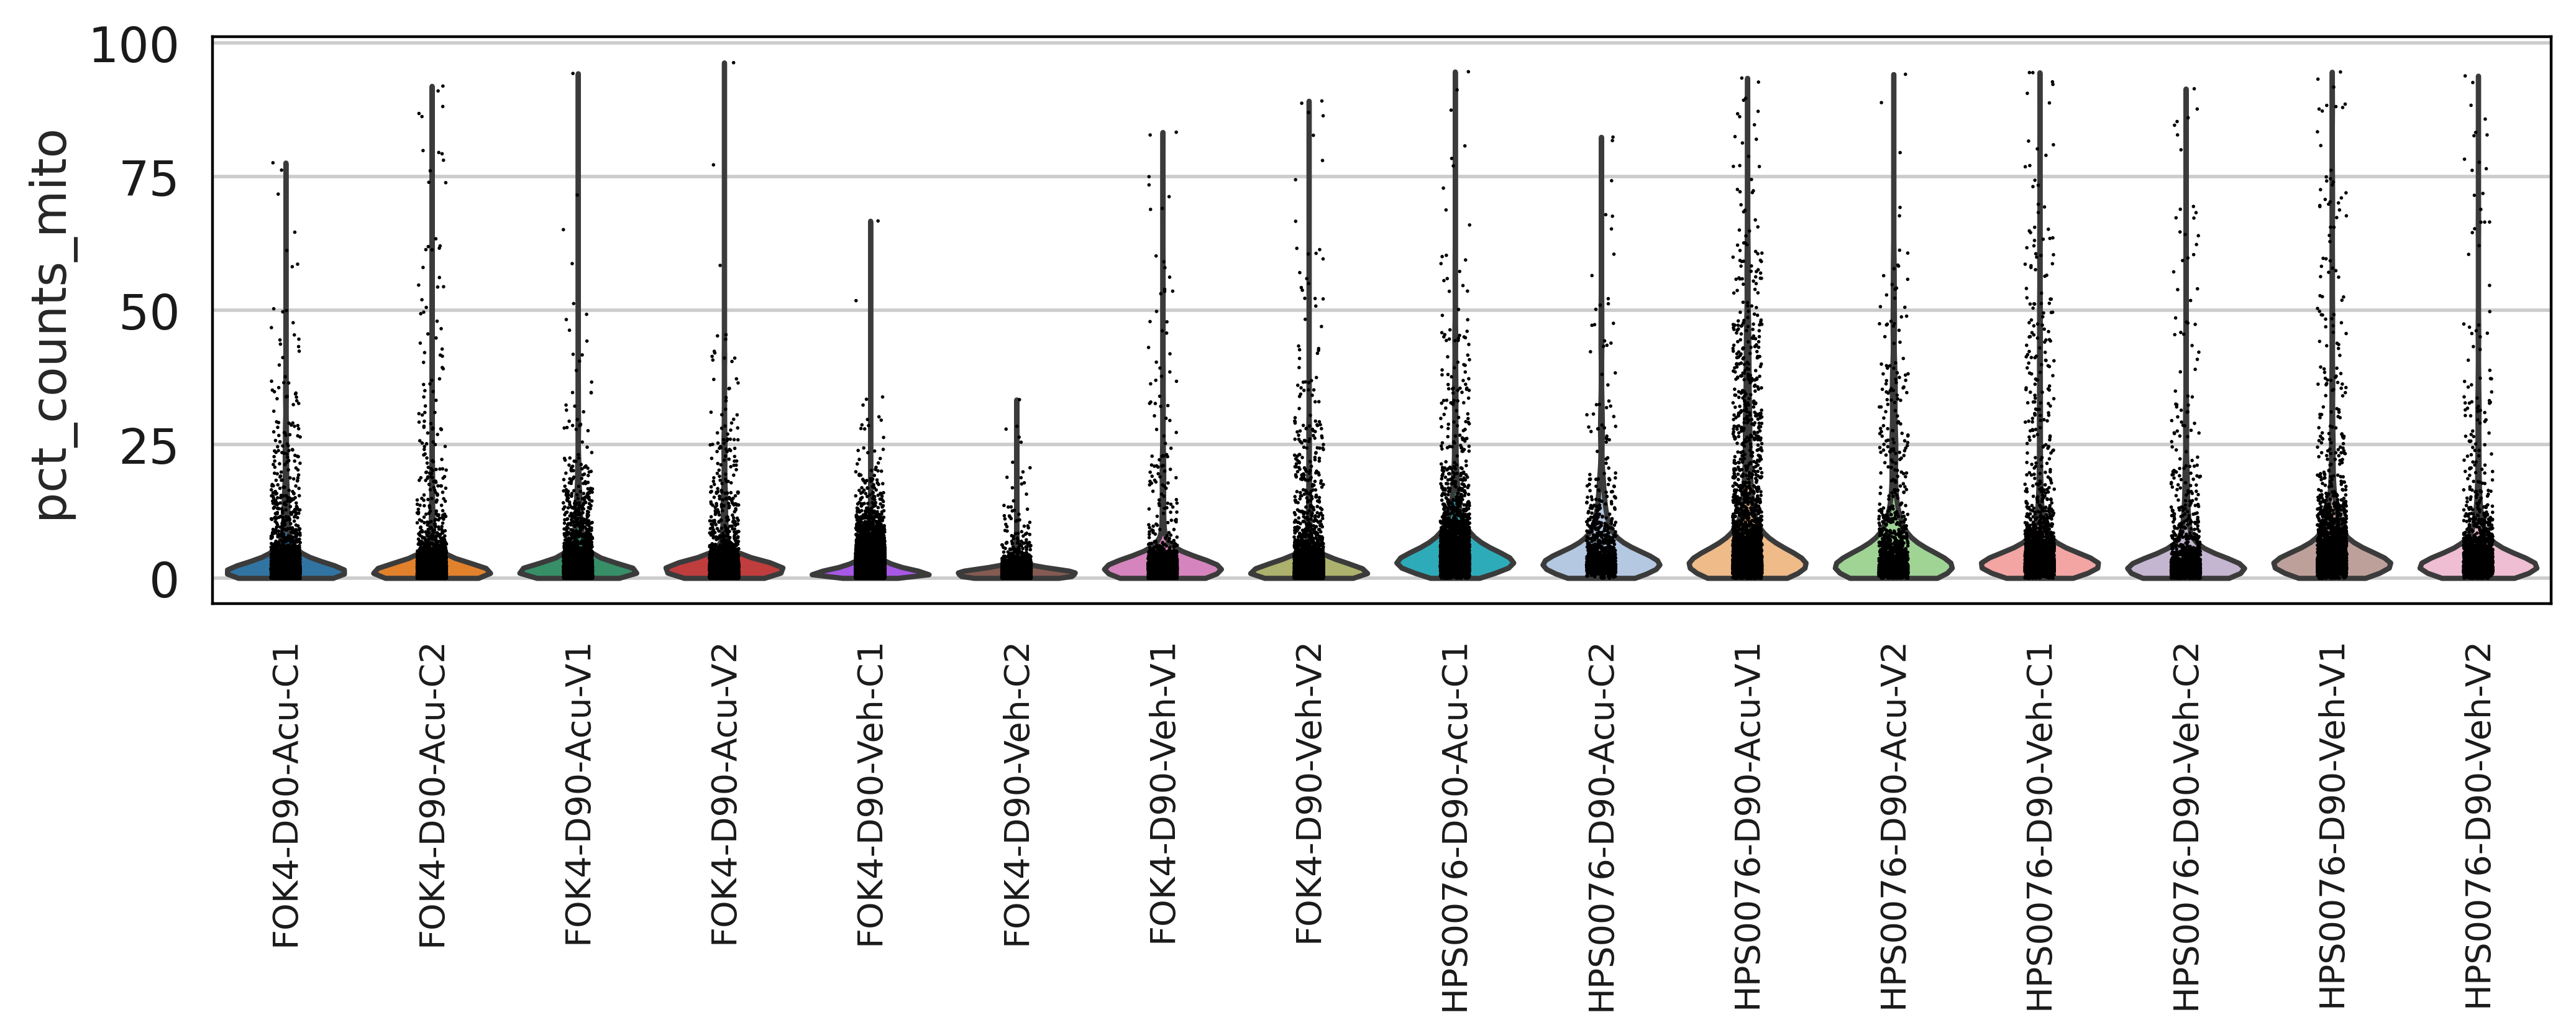

In [11]:
with plt.rc_context({"xtick.labelsize": 10, "figure.figsize": (10,3)}):
    sc.pl.violin(adata, 'pct_counts_mito', cut=0, groupby='sample', rotation=90)

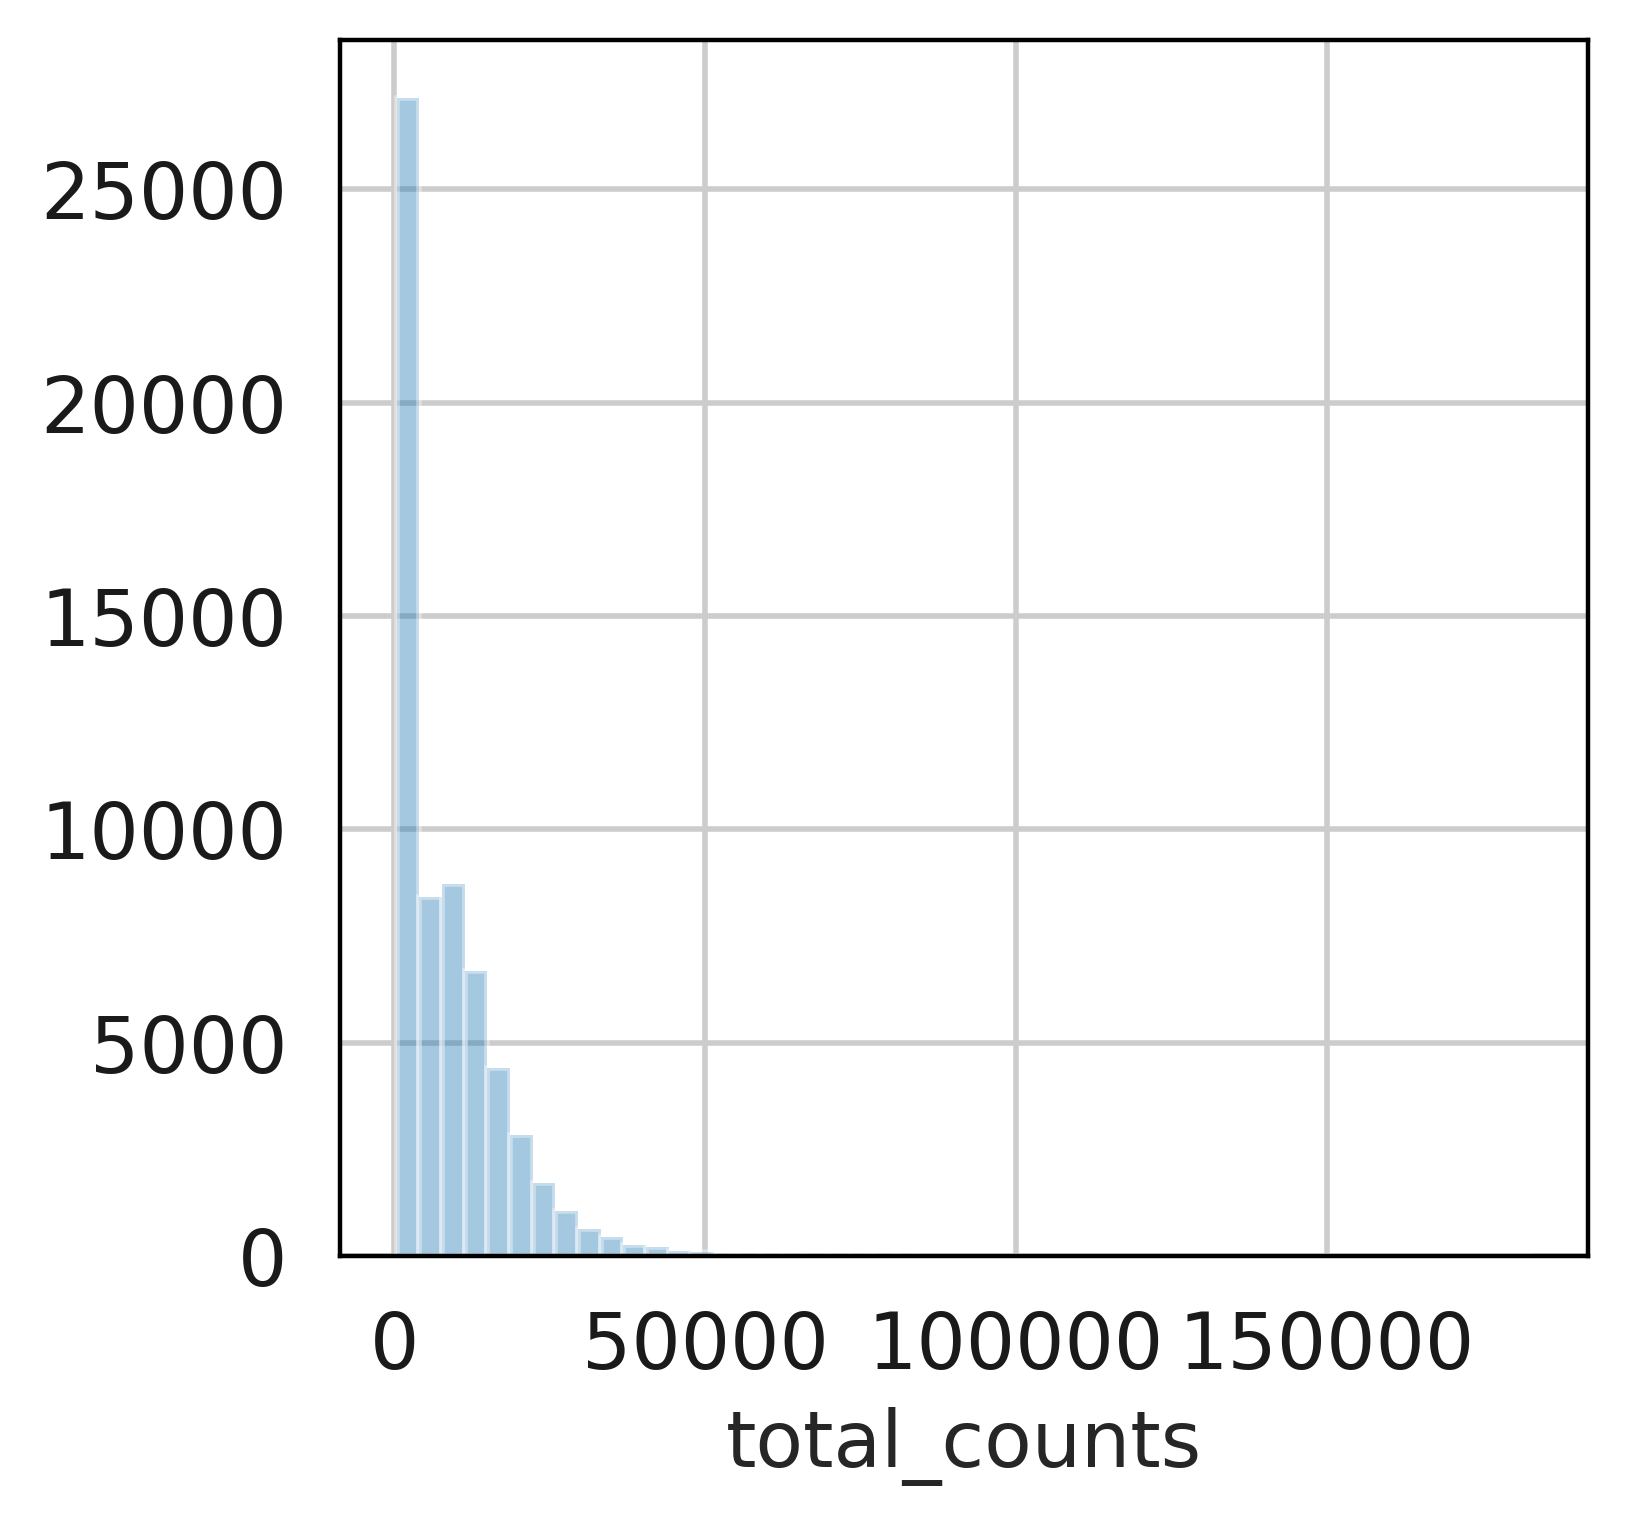

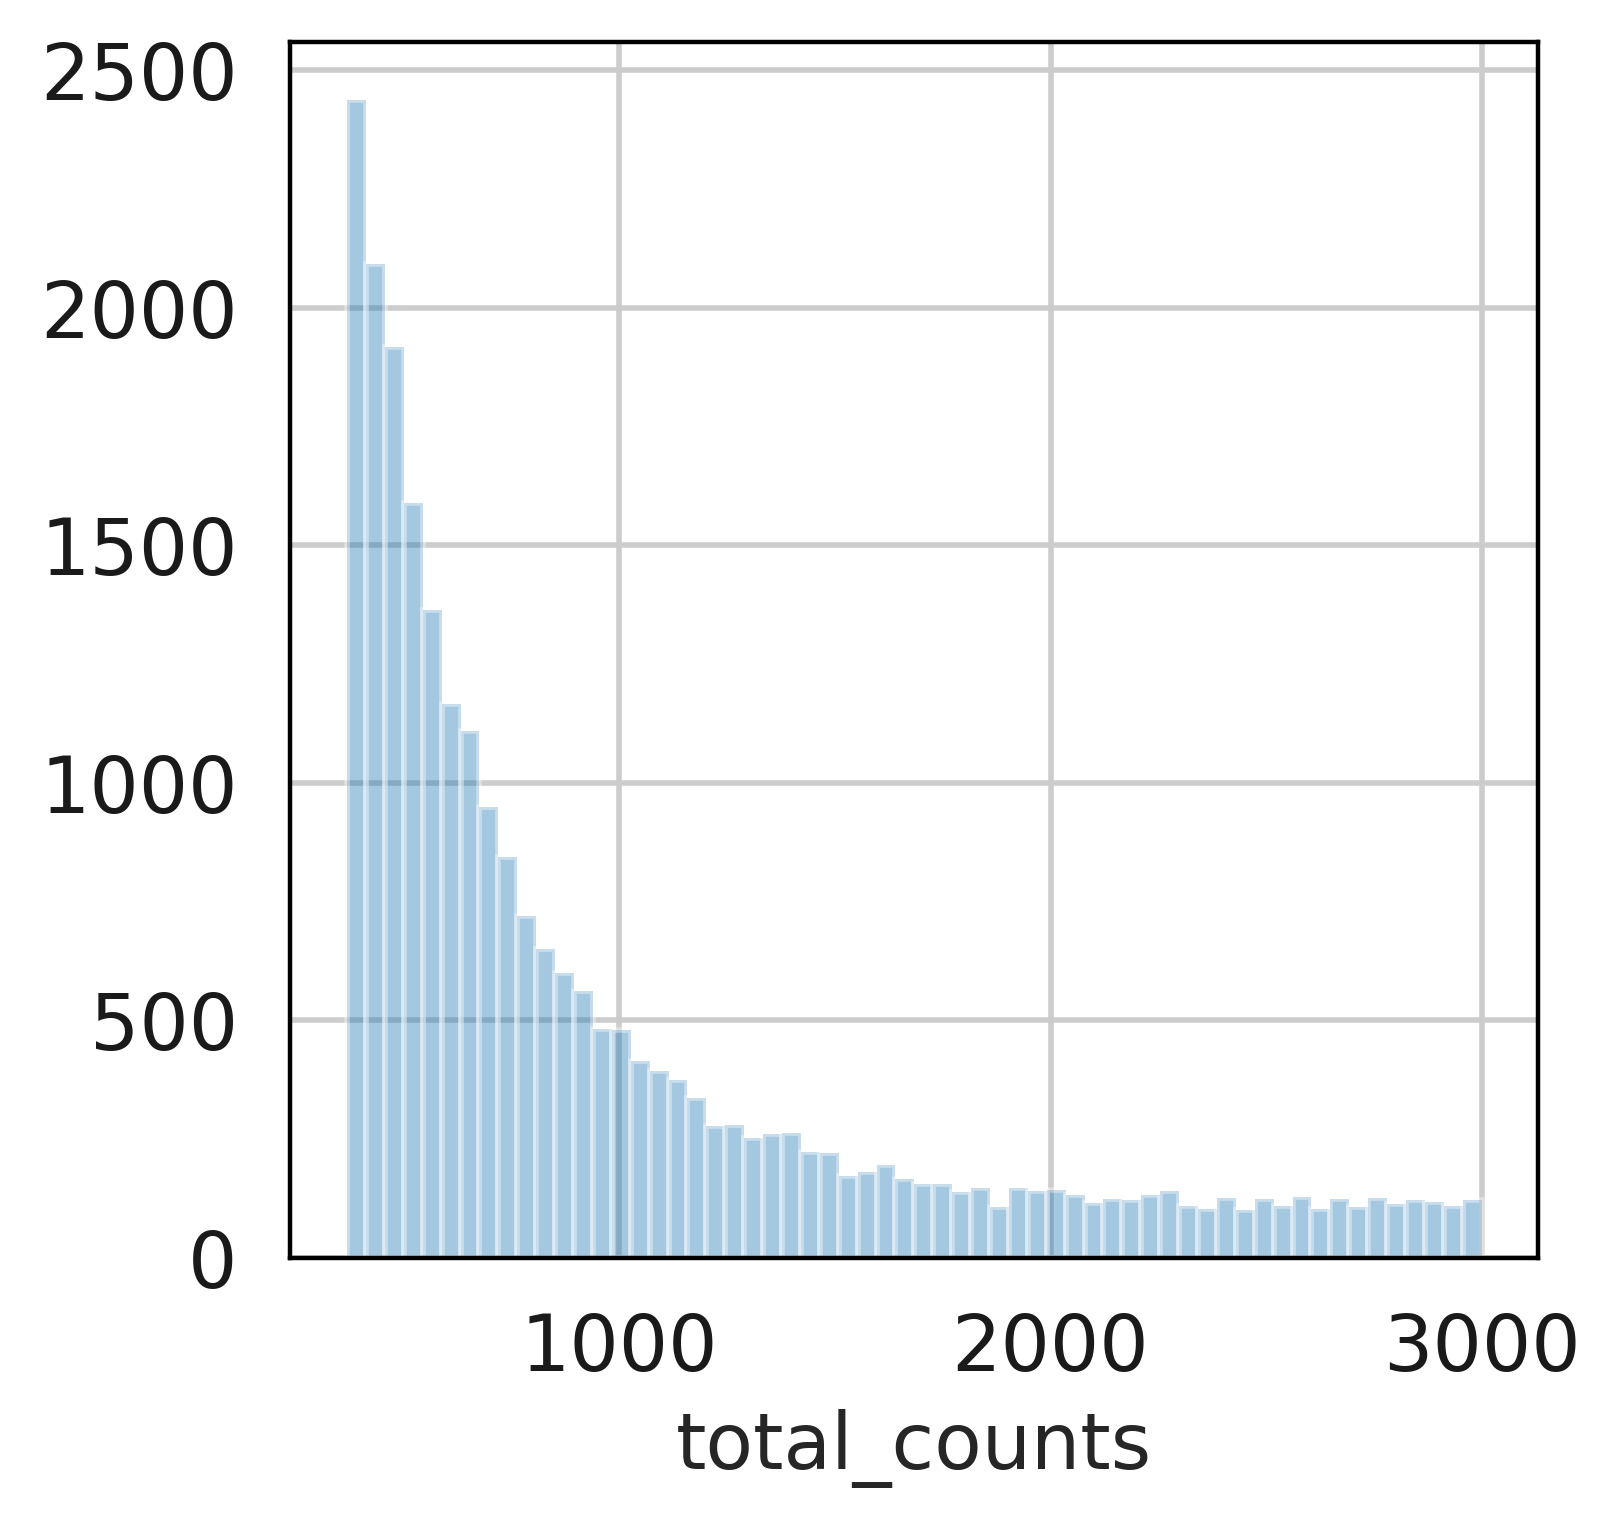

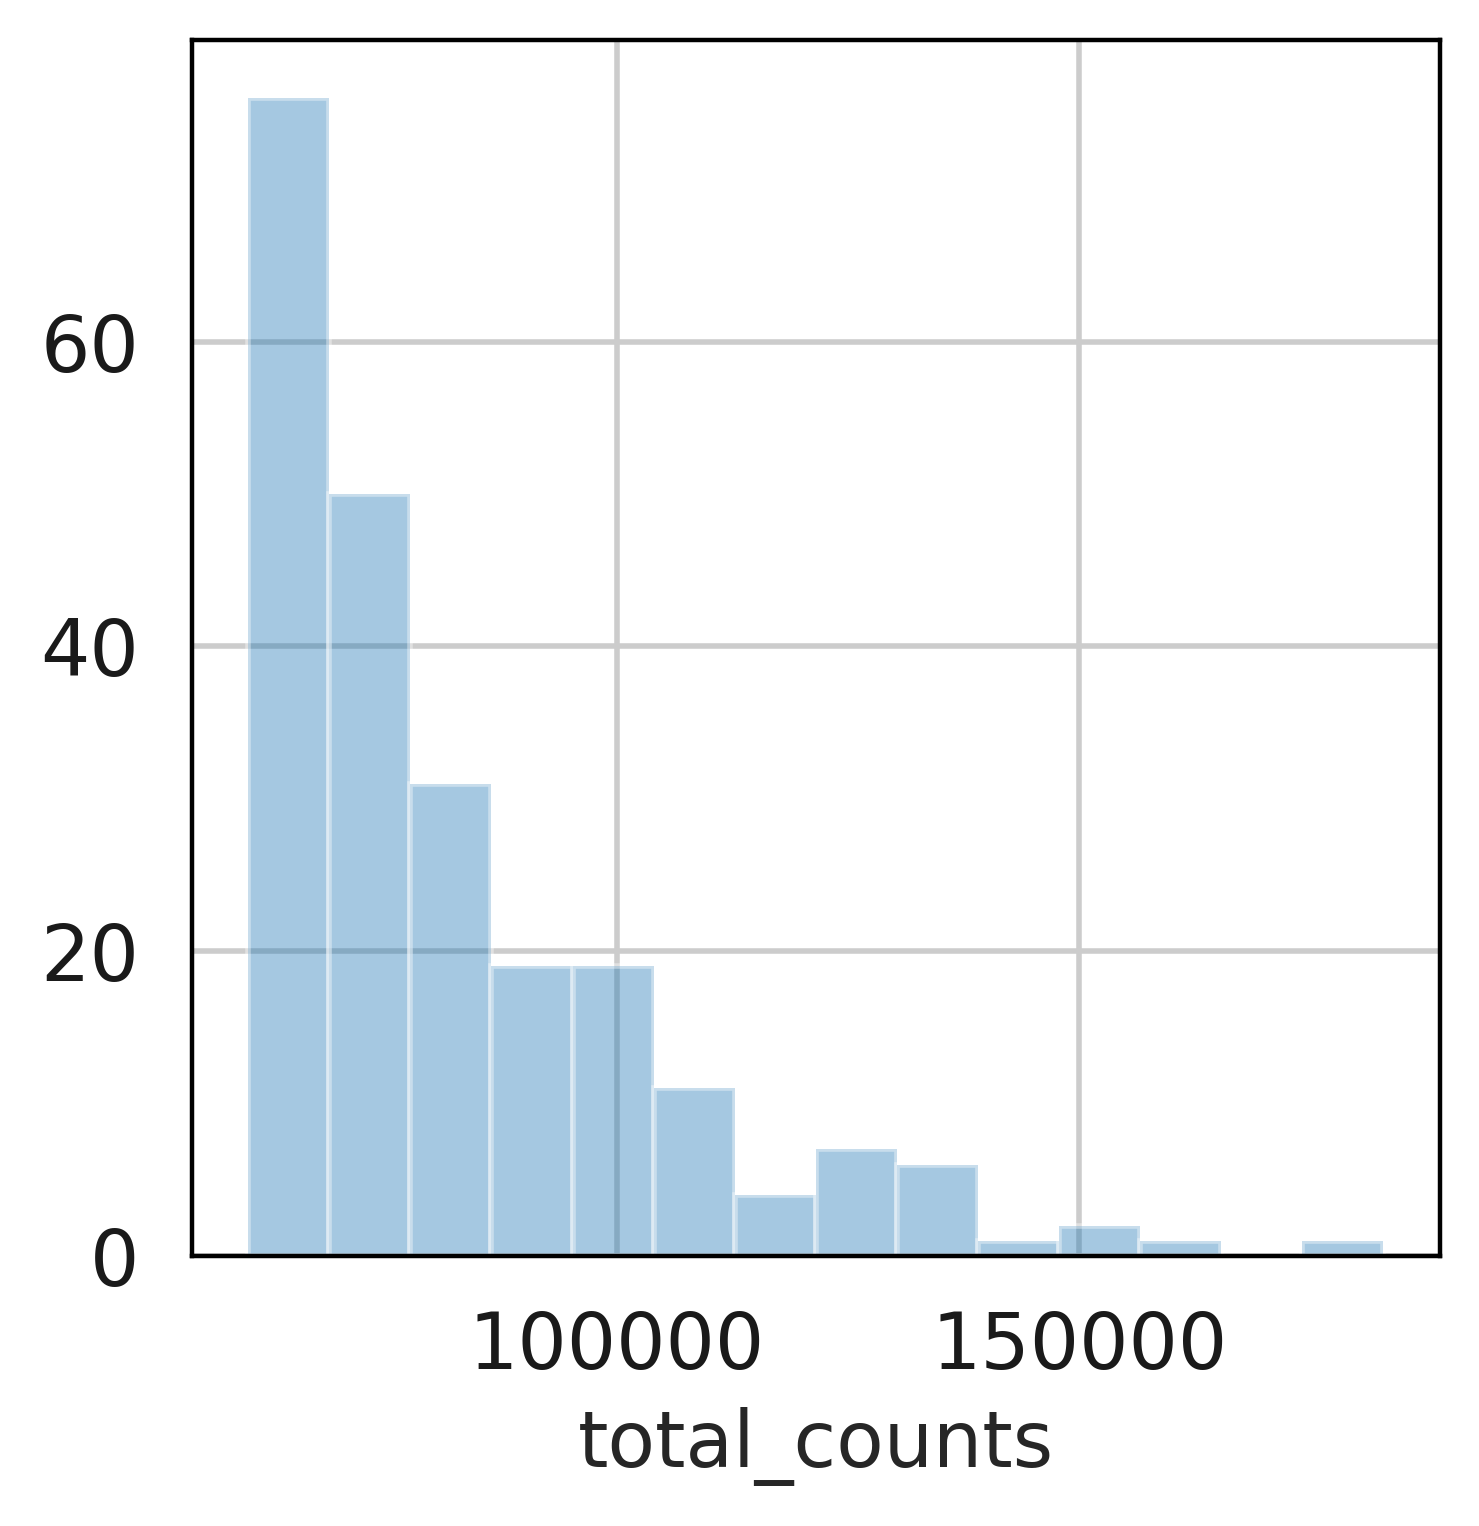

In [12]:
# Thresholding decision: counts
sns.distplot(adata.obs['total_counts'], kde=False)
plt.show()

sns.distplot(adata.obs['total_counts'][adata.obs['total_counts']<3000], kde=False, bins=60)
plt.show()

sns.distplot(adata.obs['total_counts'][adata.obs['total_counts']>60000], kde=False)
plt.show()

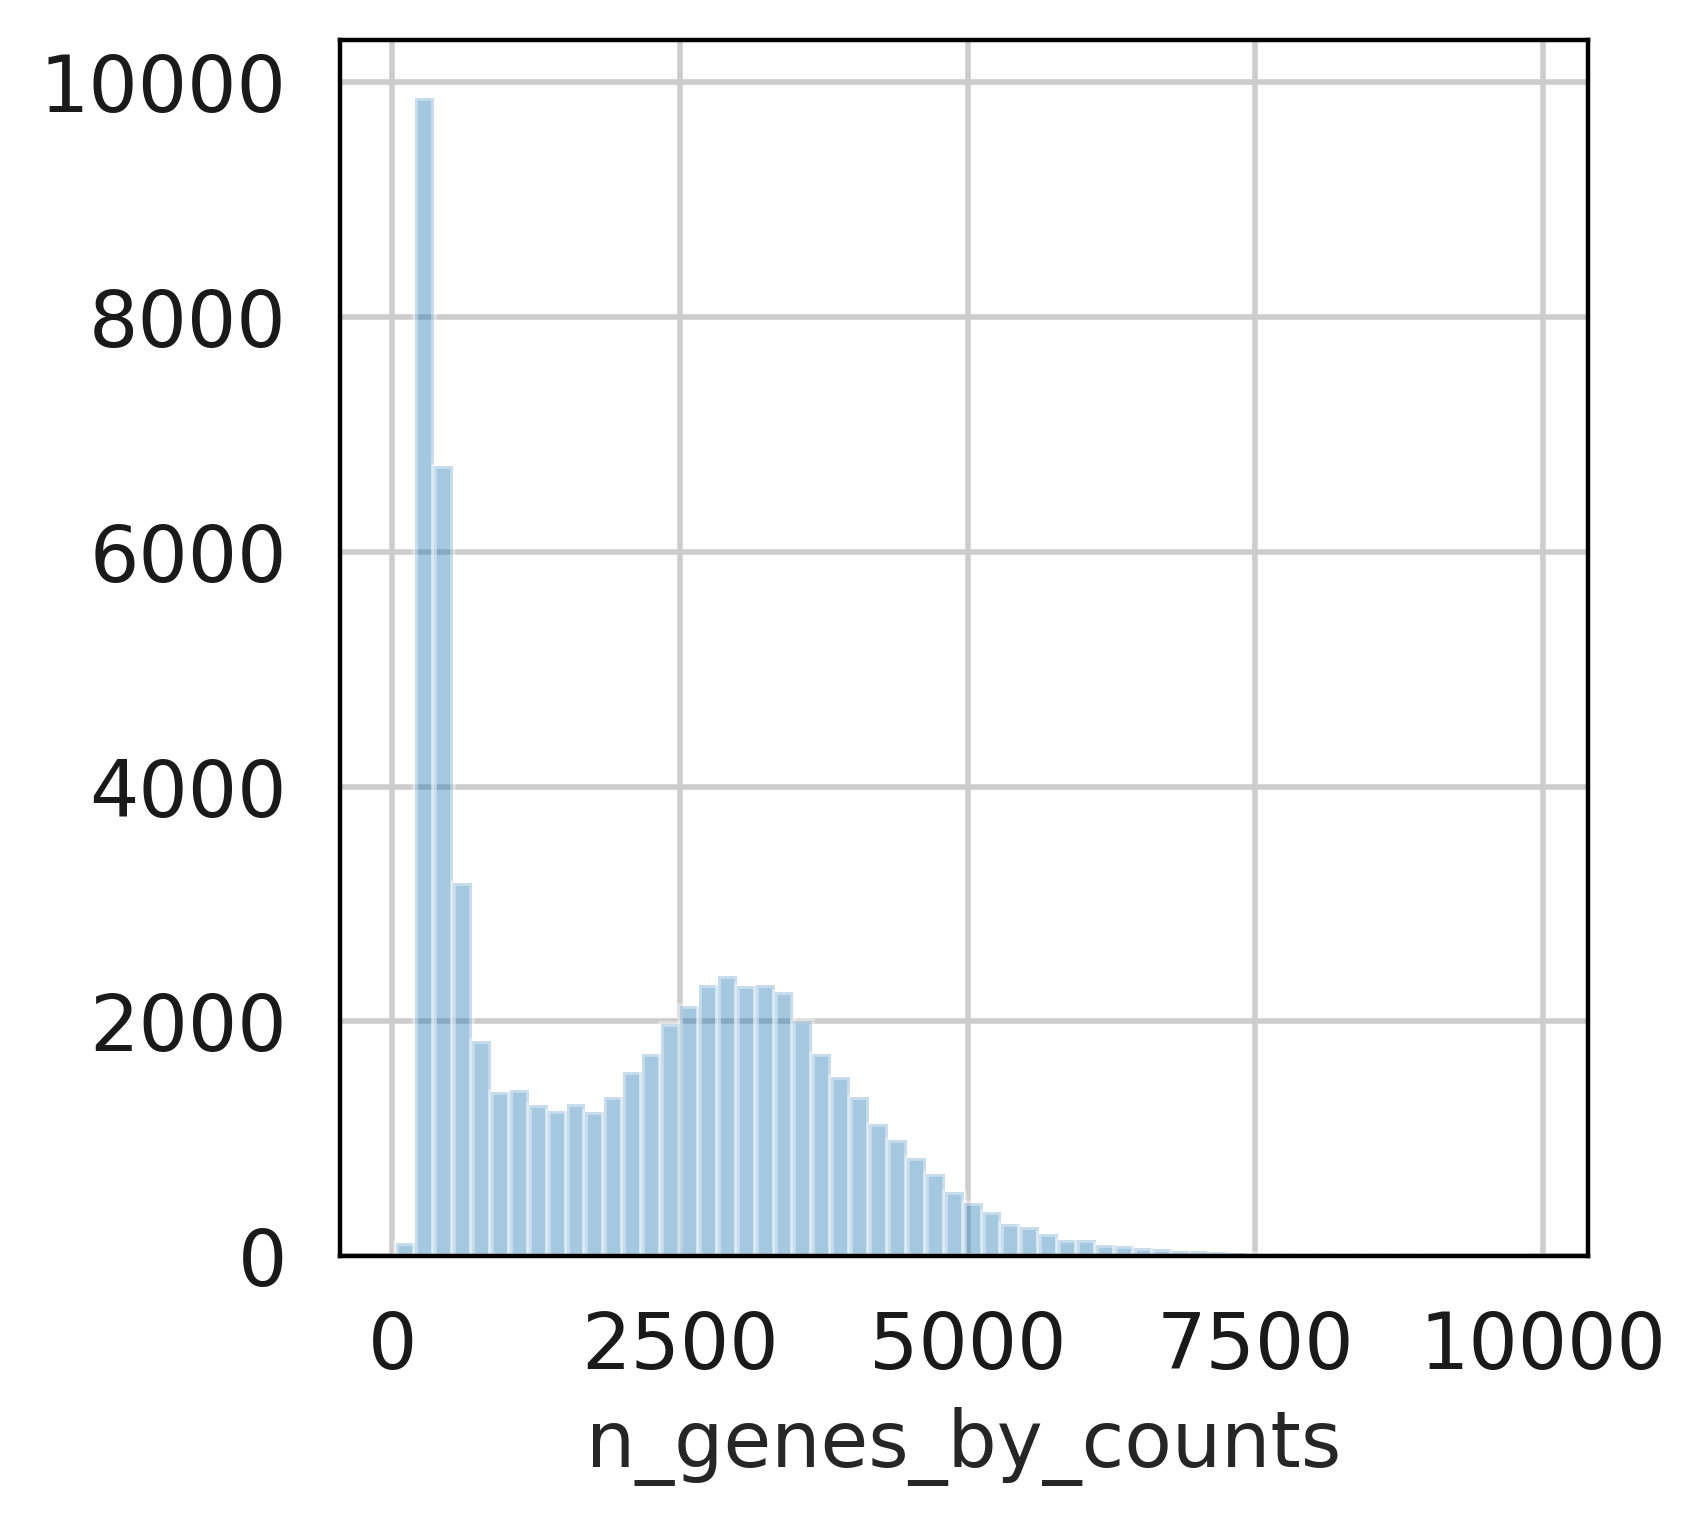

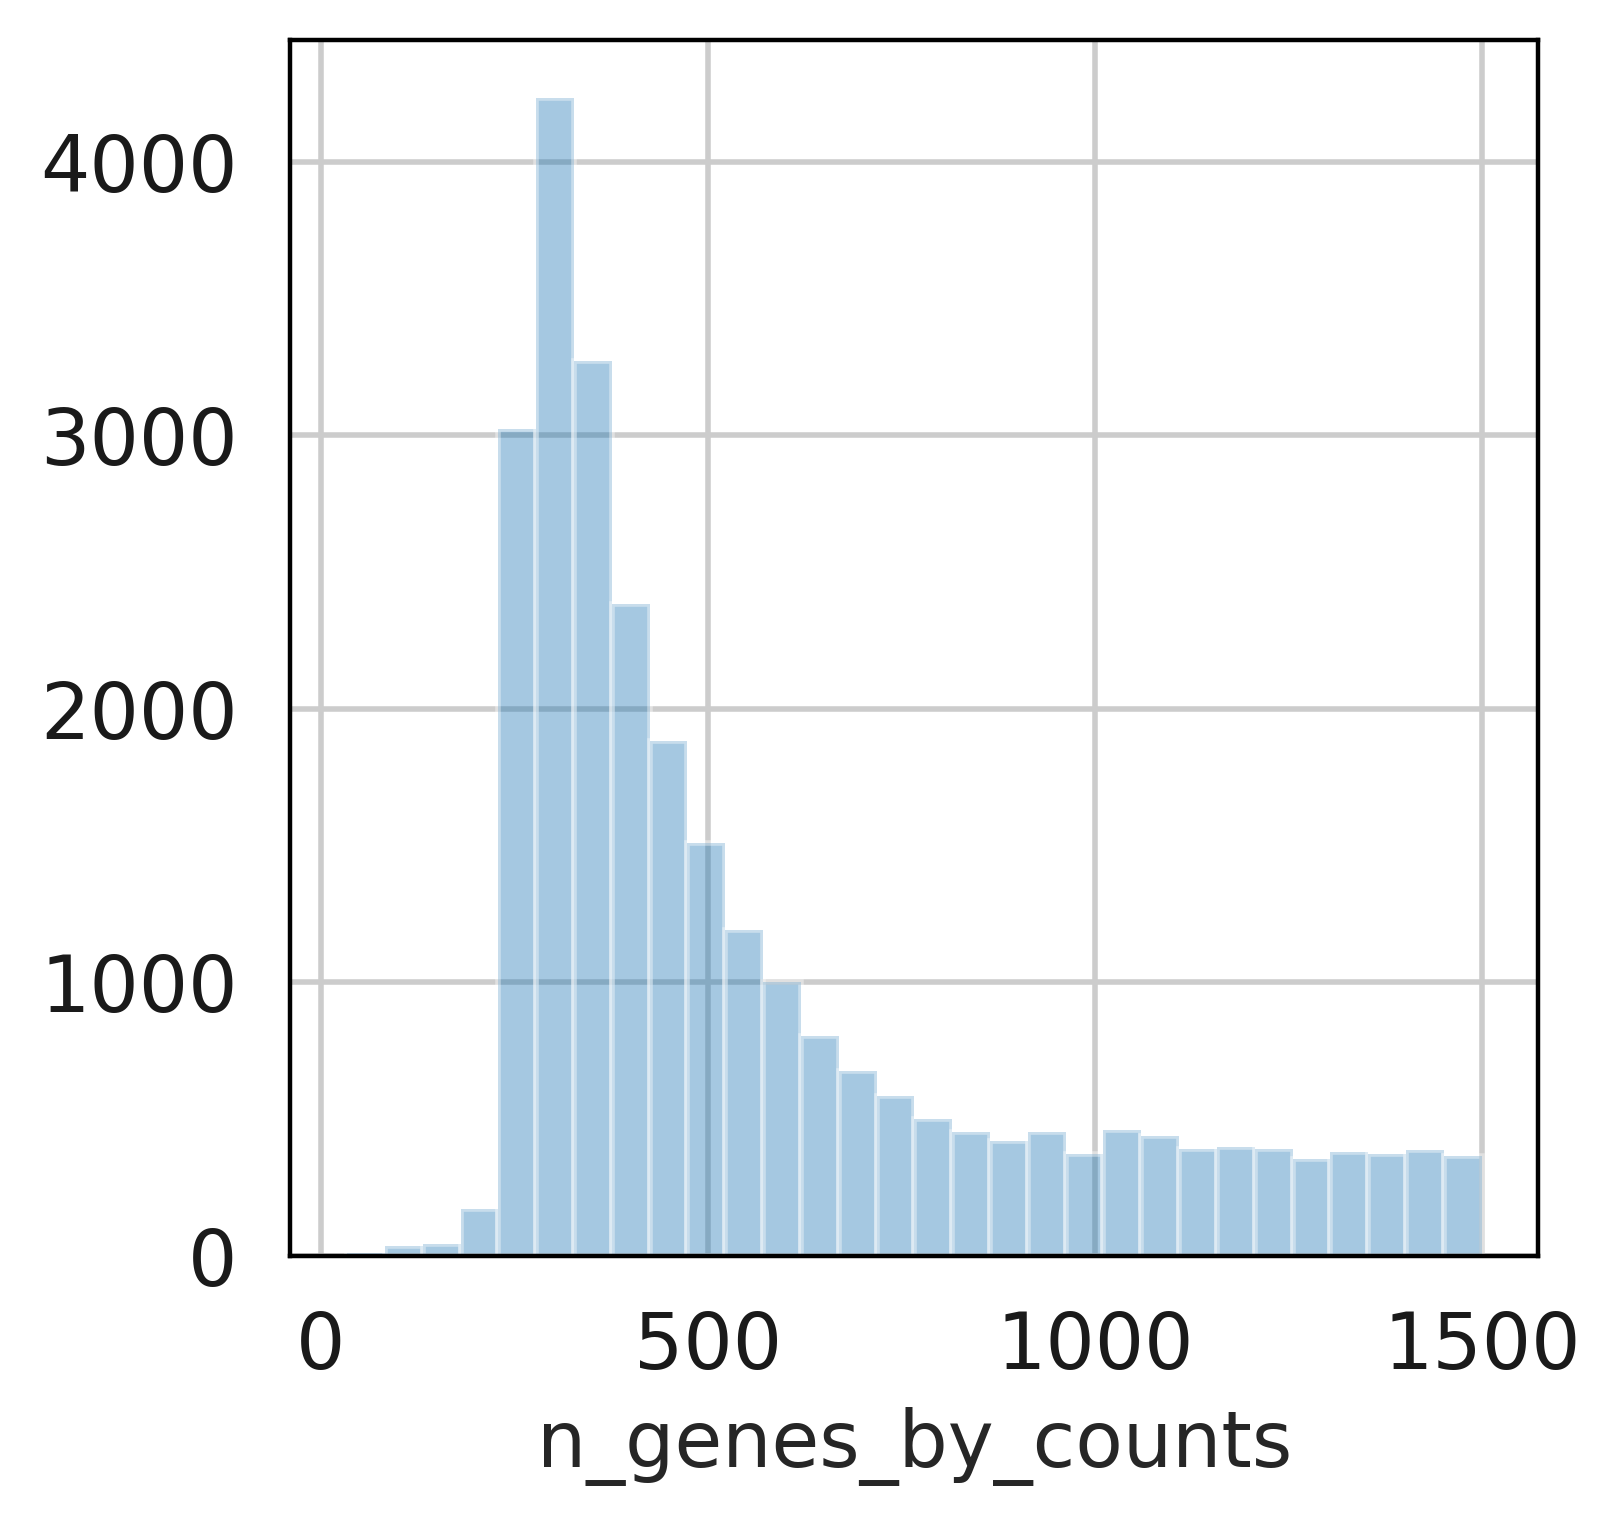

In [13]:
# Thresholding decision: genes
sns.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60)
plt.show()
sns.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<1500], kde=False, bins=30)
plt.show()

In [14]:
# Filter cells according to identified QC thresholds:
print('Total number of cells before filtering: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts = 1200)
sc.pp.filter_cells(adata, min_genes = 700)
sc.pp.filter_cells(adata, max_counts = 150000)

mito_thresh = 25.0
n1 = adata.n_obs
adata = adata[adata.obs['pct_counts_mito'] < mito_thresh]
print('filtered out {:d} cells that have more than or equal to {:d}% mitochondrial counts'.format((n1 - adata.n_obs), int(mito_thresh)))
del n1, mito_thresh

print('Total number of cells after filtering: {:d}'.format(adata.n_obs))

Total number of cells before filtering: 63052
filtered out 18451 cells that have less than 1200 counts
filtered out 1661 cells that have less than 700 genes expressed
filtered out 3 cells that have more than 150000 counts
filtered out 414 cells that have more than or equal to 25% mitochondrial counts
Total number of cells after filtering: 42523


In [15]:
# Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 58735
filtered out 32026 genes that are detected in less than 20 cells


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 26709


In [16]:
# Recalculate qc metrics
del adata.obs['n_counts']
del adata.var['n_cells']
sc.pp.calculate_qc_metrics(adata, qc_vars=(['mito']), inplace=True)

# Cell Line 2 (FOK4)

## CL2 Preprocess Data

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:22)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 19 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:03)


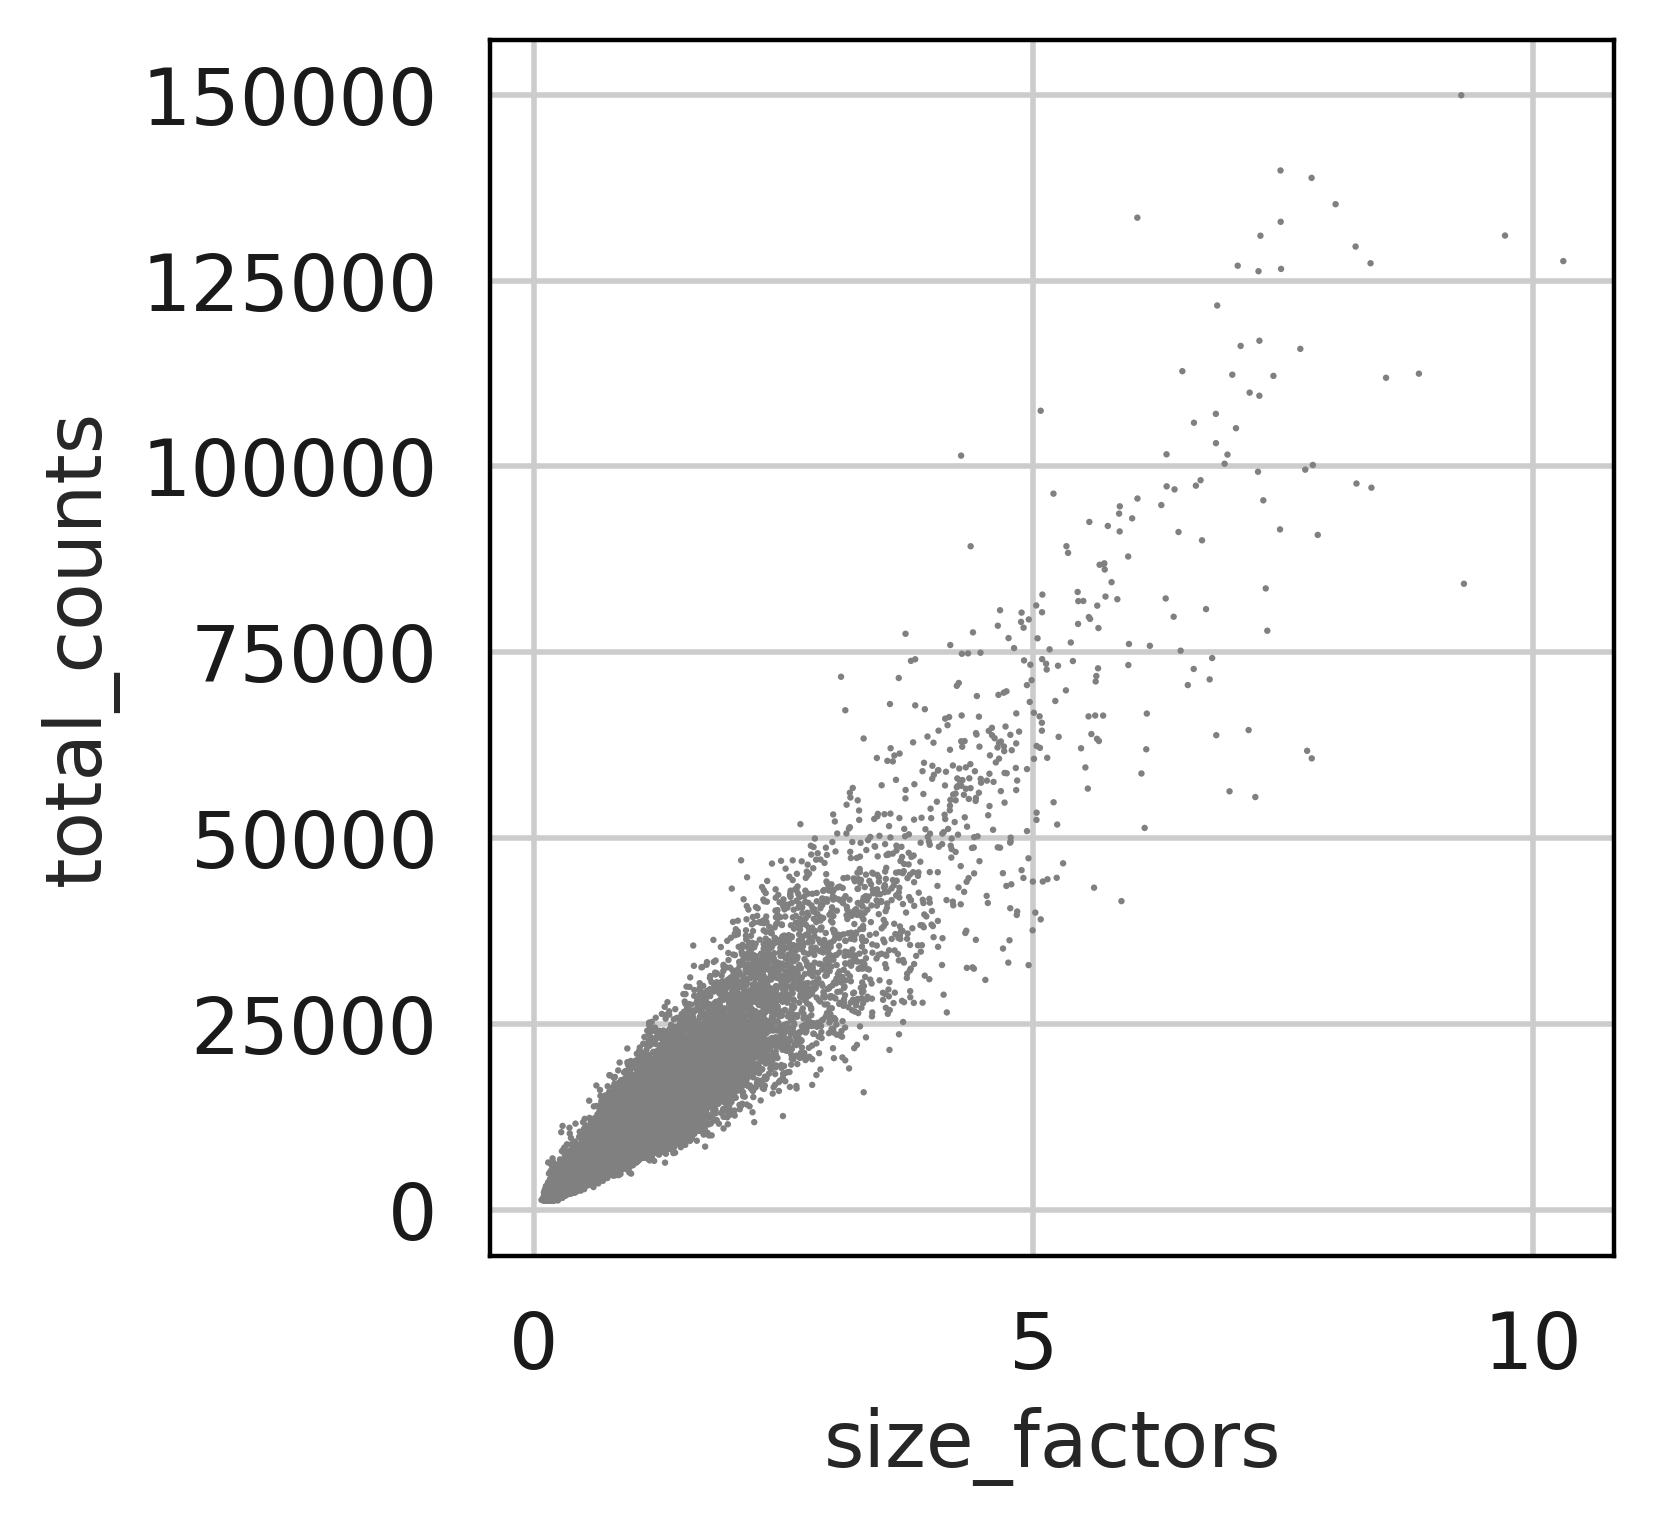

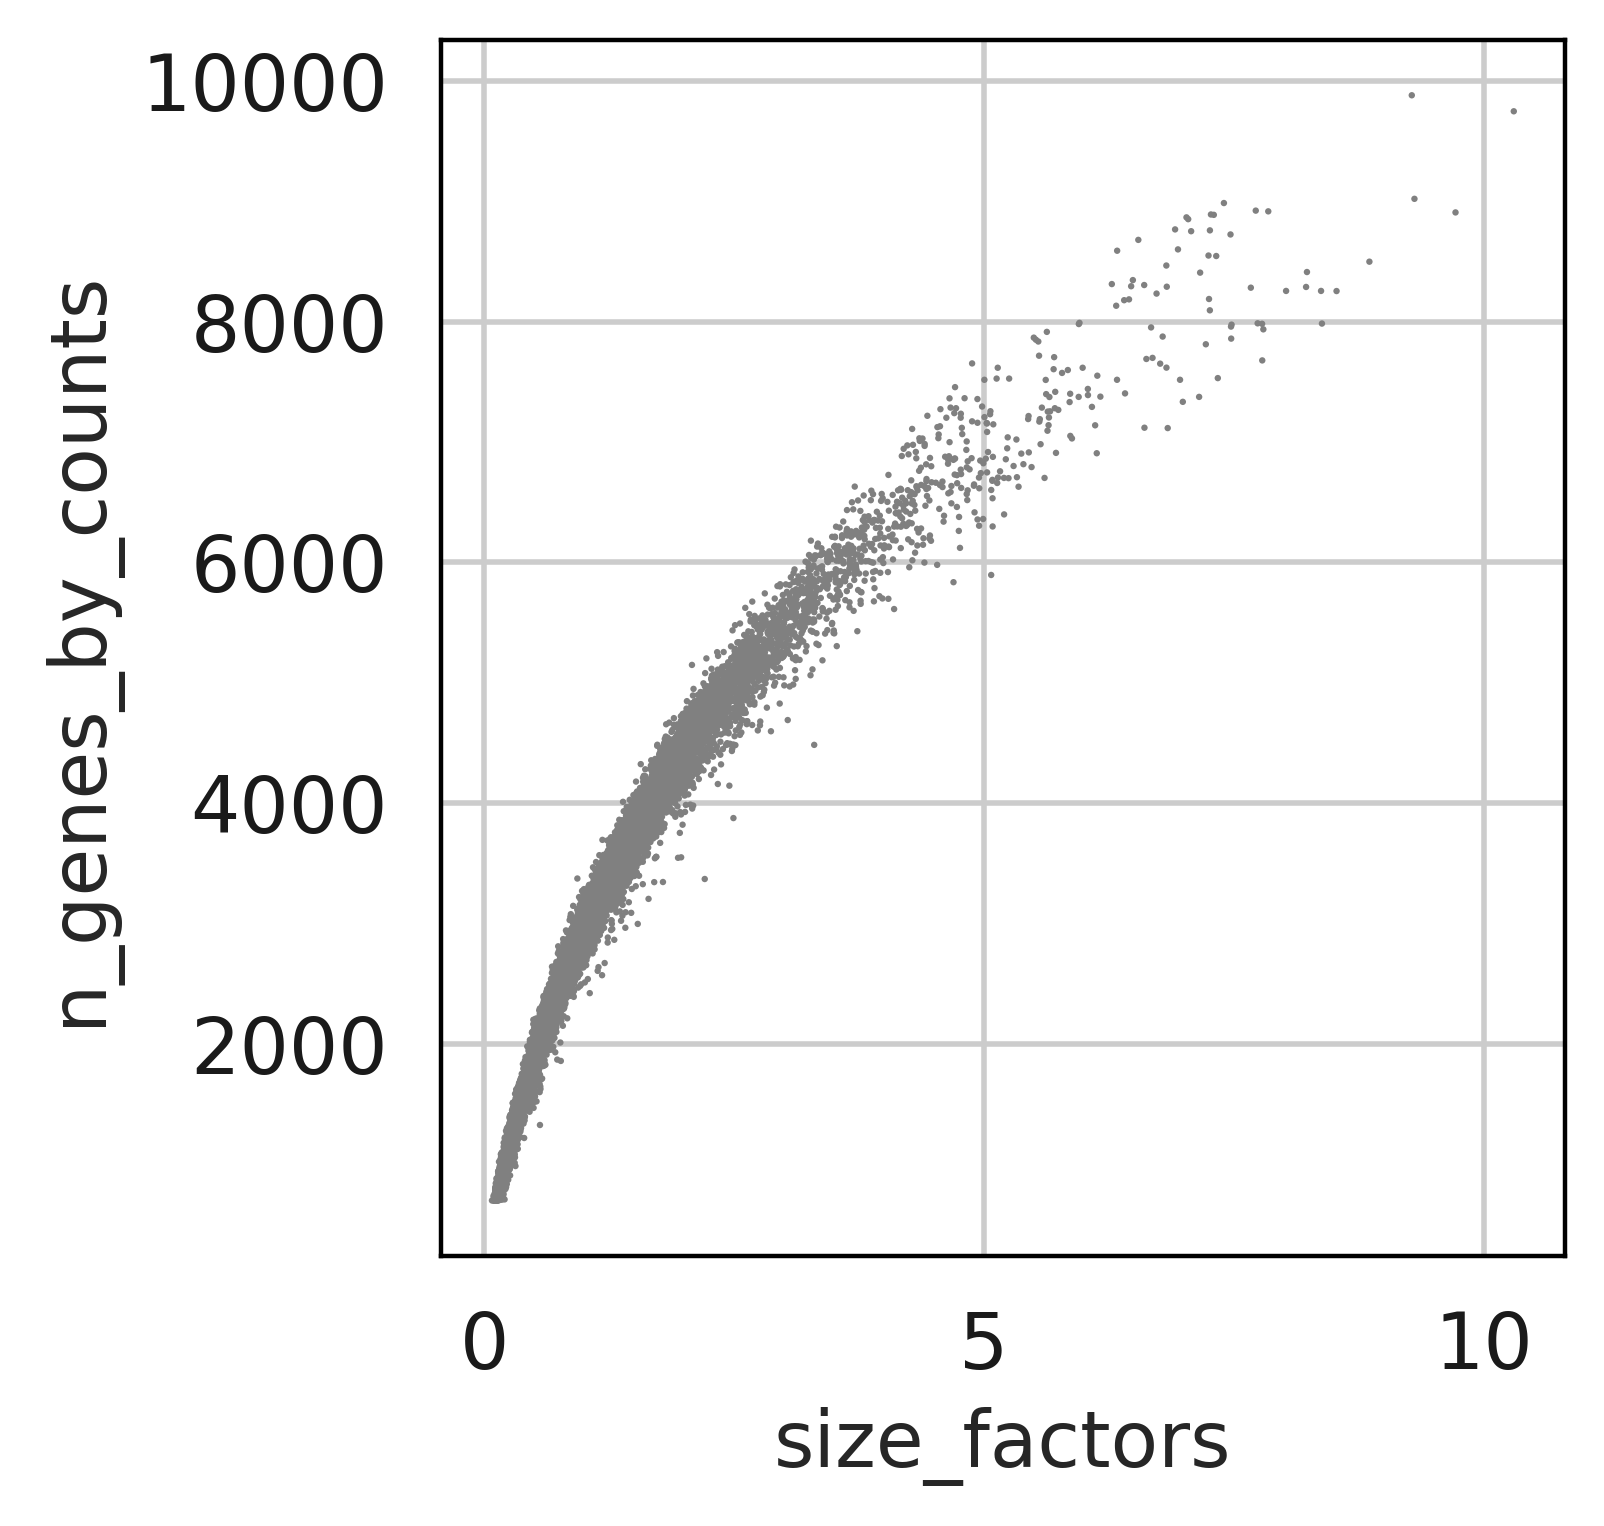

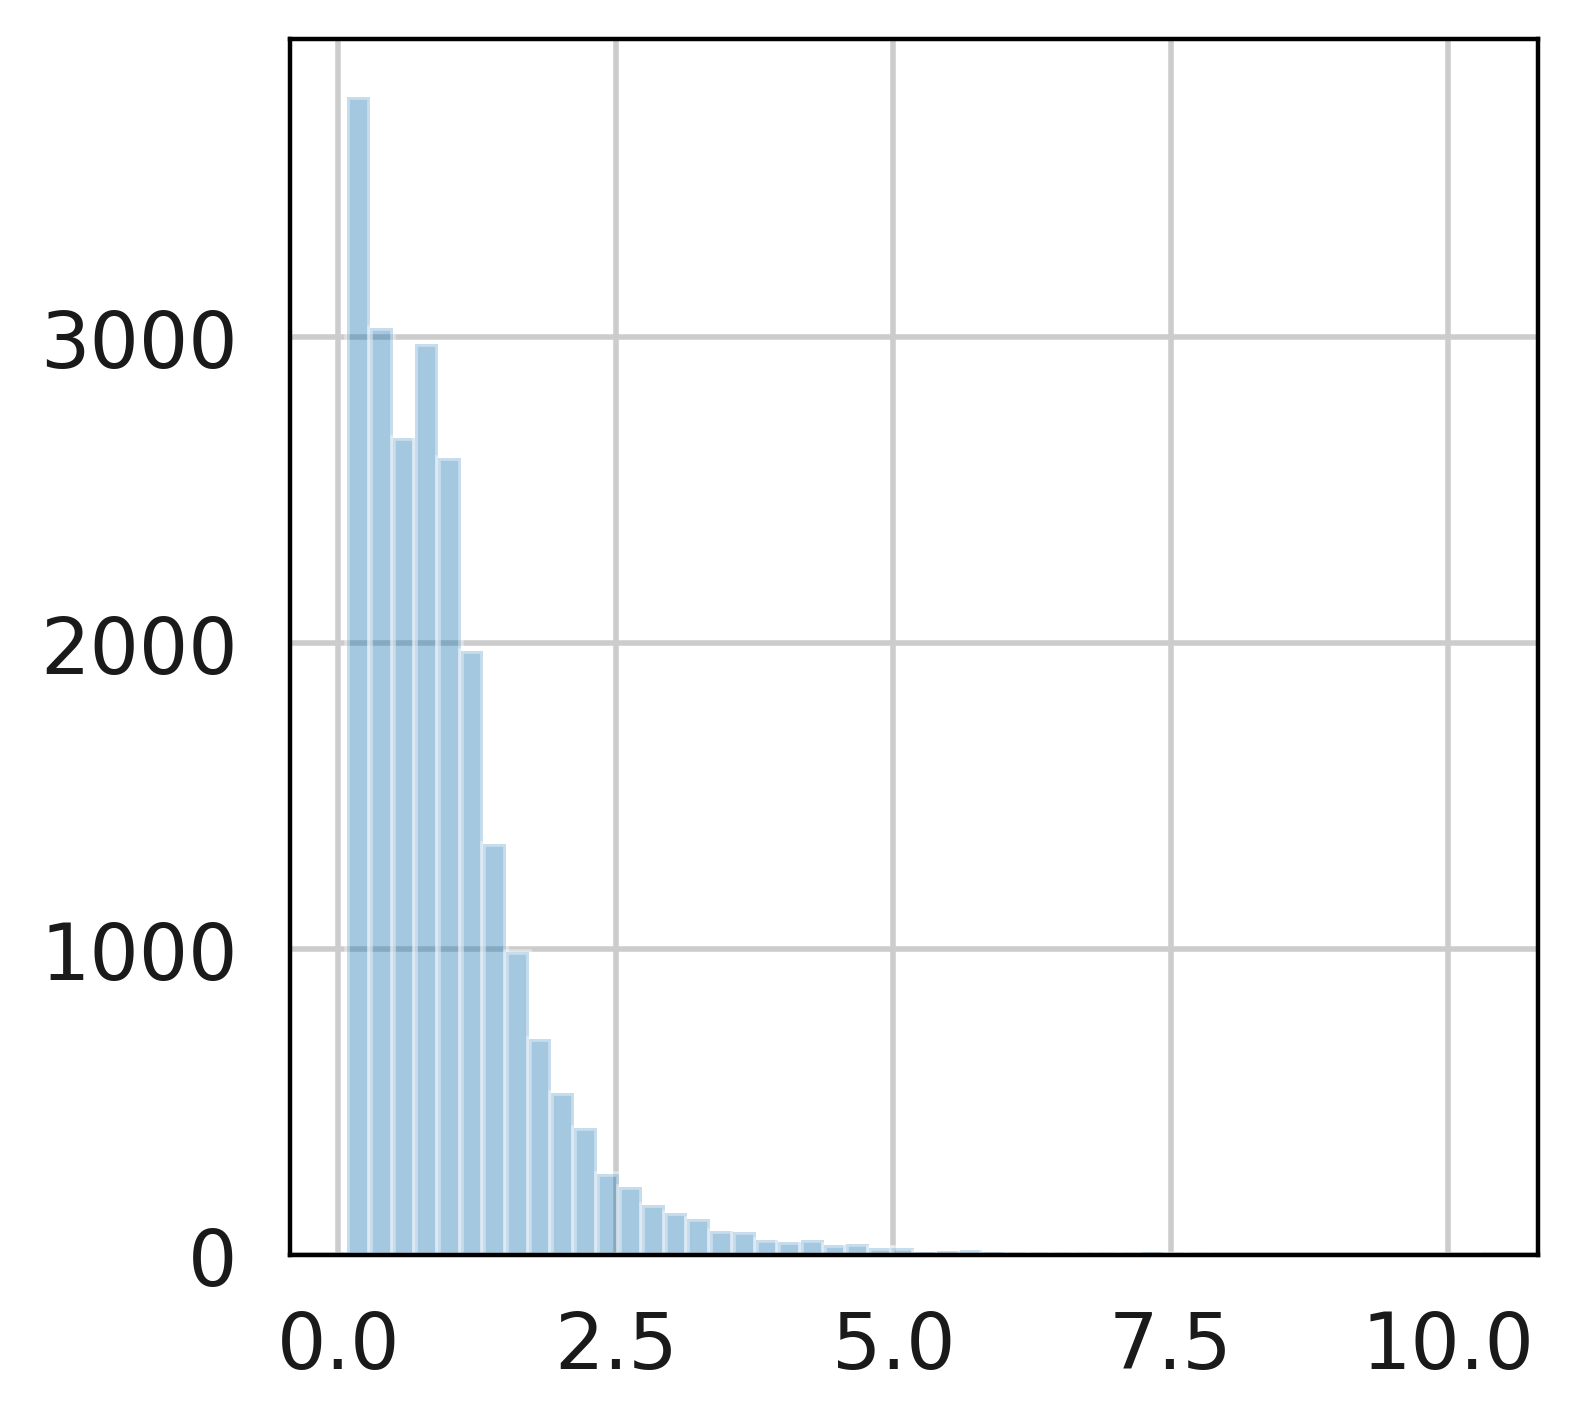

In [30]:
# Create object for Cell Line 2
adata_fok = adata[adata.obs["cellline"] == "FOK4"].copy()
adata_fok = adata_fok[adata_fok.obs["louvain_three"] != "unassigned"].copy()
adata_fok.obs["louvain_three"] = adata_fok.obs["louvain_three"].cat.remove_unused_categories()
fok_clusters_three = list(adata_fok.obs['louvain_three'].cat.categories)

# Densify adata
adata_fok.layers["counts"] = adata_fok.X.copy()
adata_fok.X = adata_fok.X.A

# Perform a clustering for improved scran normalization in clusters
adata_pp = adata_fok.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=50, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

# Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = np.array(adata_fok.X.T)
del adata_pp

# Run scran
%R -i input_groups -i data_mat -o size_factors size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

# Visualize the estimated size factors
adata_fok.obs['size_factors'] = size_factors
sc.pl.scatter(adata_fok, 'size_factors', 'total_counts')
sc.pl.scatter(adata_fok, 'size_factors', 'n_genes_by_counts')
sns.distplot(size_factors, bins=50, kde=False)
plt.show()

del data_mat, input_groups

In [31]:
# LogNormalize adata 
adata_fok.X /= adata_fok.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_fok)

# Keep normalised data in seperate layer
adata_fok.layers["scran"] = scipy.sparse.csr_matrix(adata_fok.X).copy()

# Check dropout
print("Dropout:", np.sum(adata_fok.X == 0)/np.size(adata_fok.X))

# Annotate highly variable genes
sc.pp.highly_variable_genes(adata_fok, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_fok.var['highly_variable'])))
adata_fok.X = scipy.sparse.csr_matrix(adata_fok.X)

Dropout: 0.8994879999661861
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 4000


In [32]:
sc.pp.pca(adata_fok)
sc.pp.neighbors(adata_fok)
sc.tl.umap(adata_fok)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:18)


## CL2 Data overview

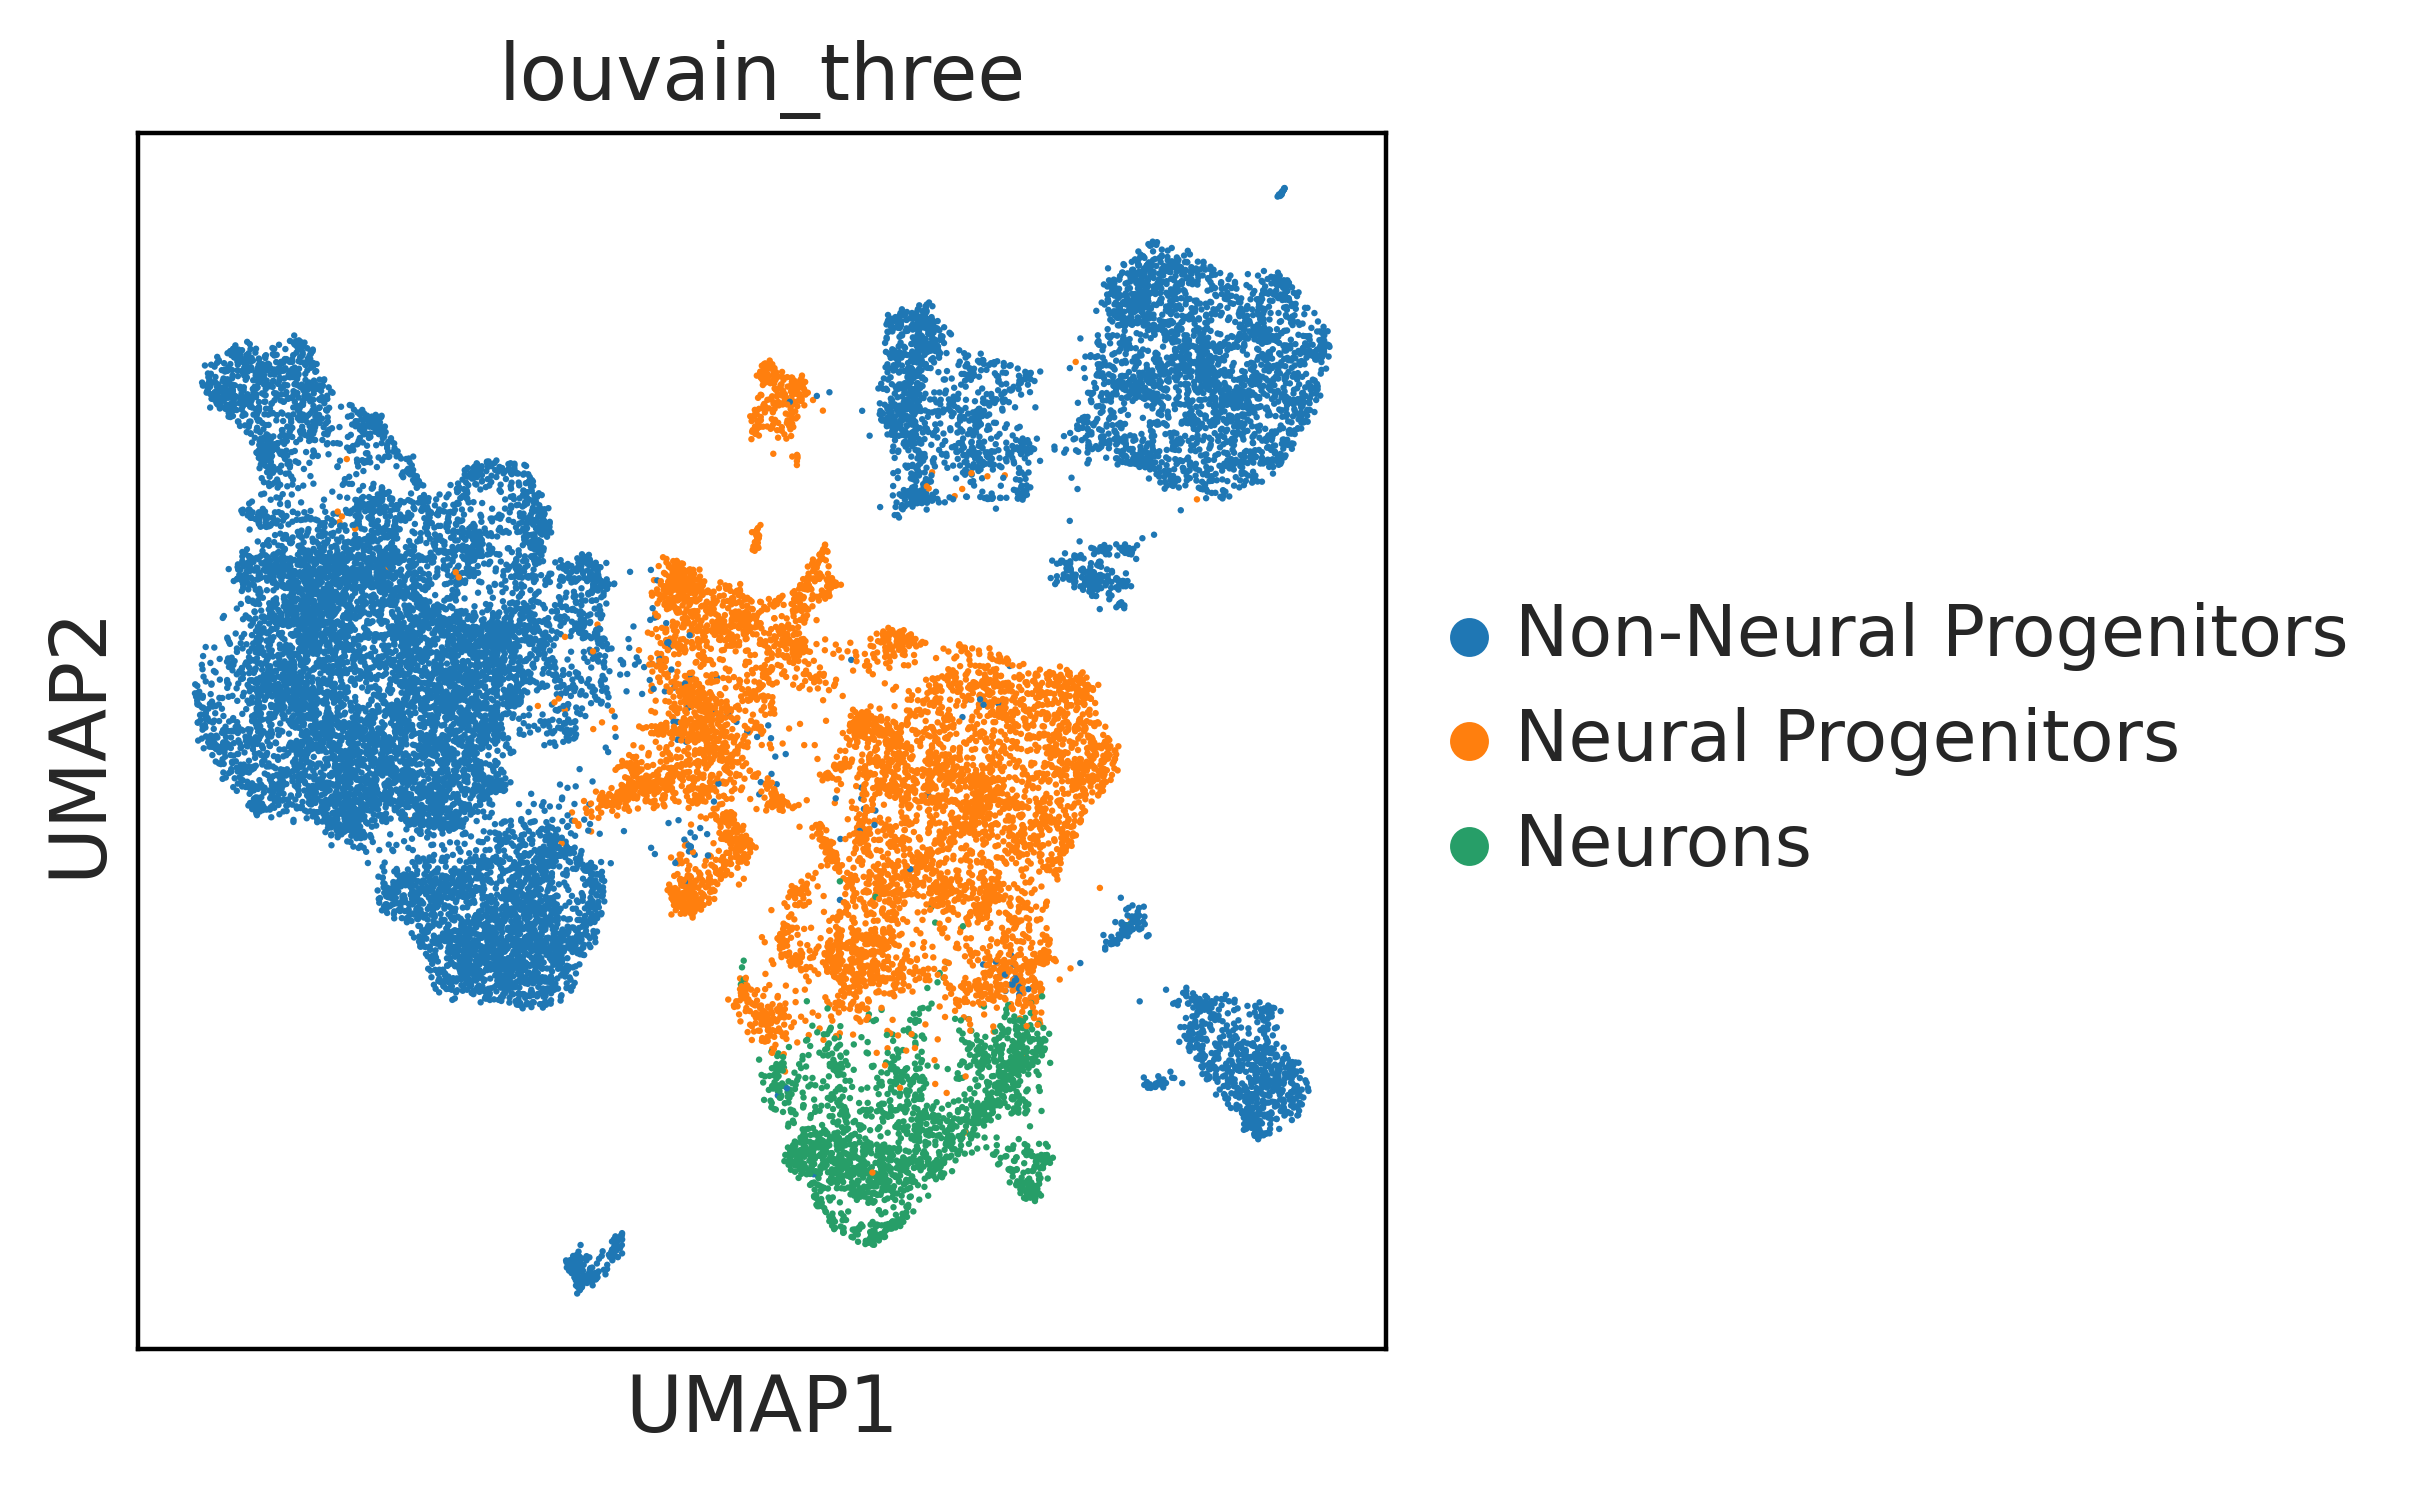

In [41]:
sc.pl.umap(adata_fok, color='louvain_three', save='_fok_threegroups.png')

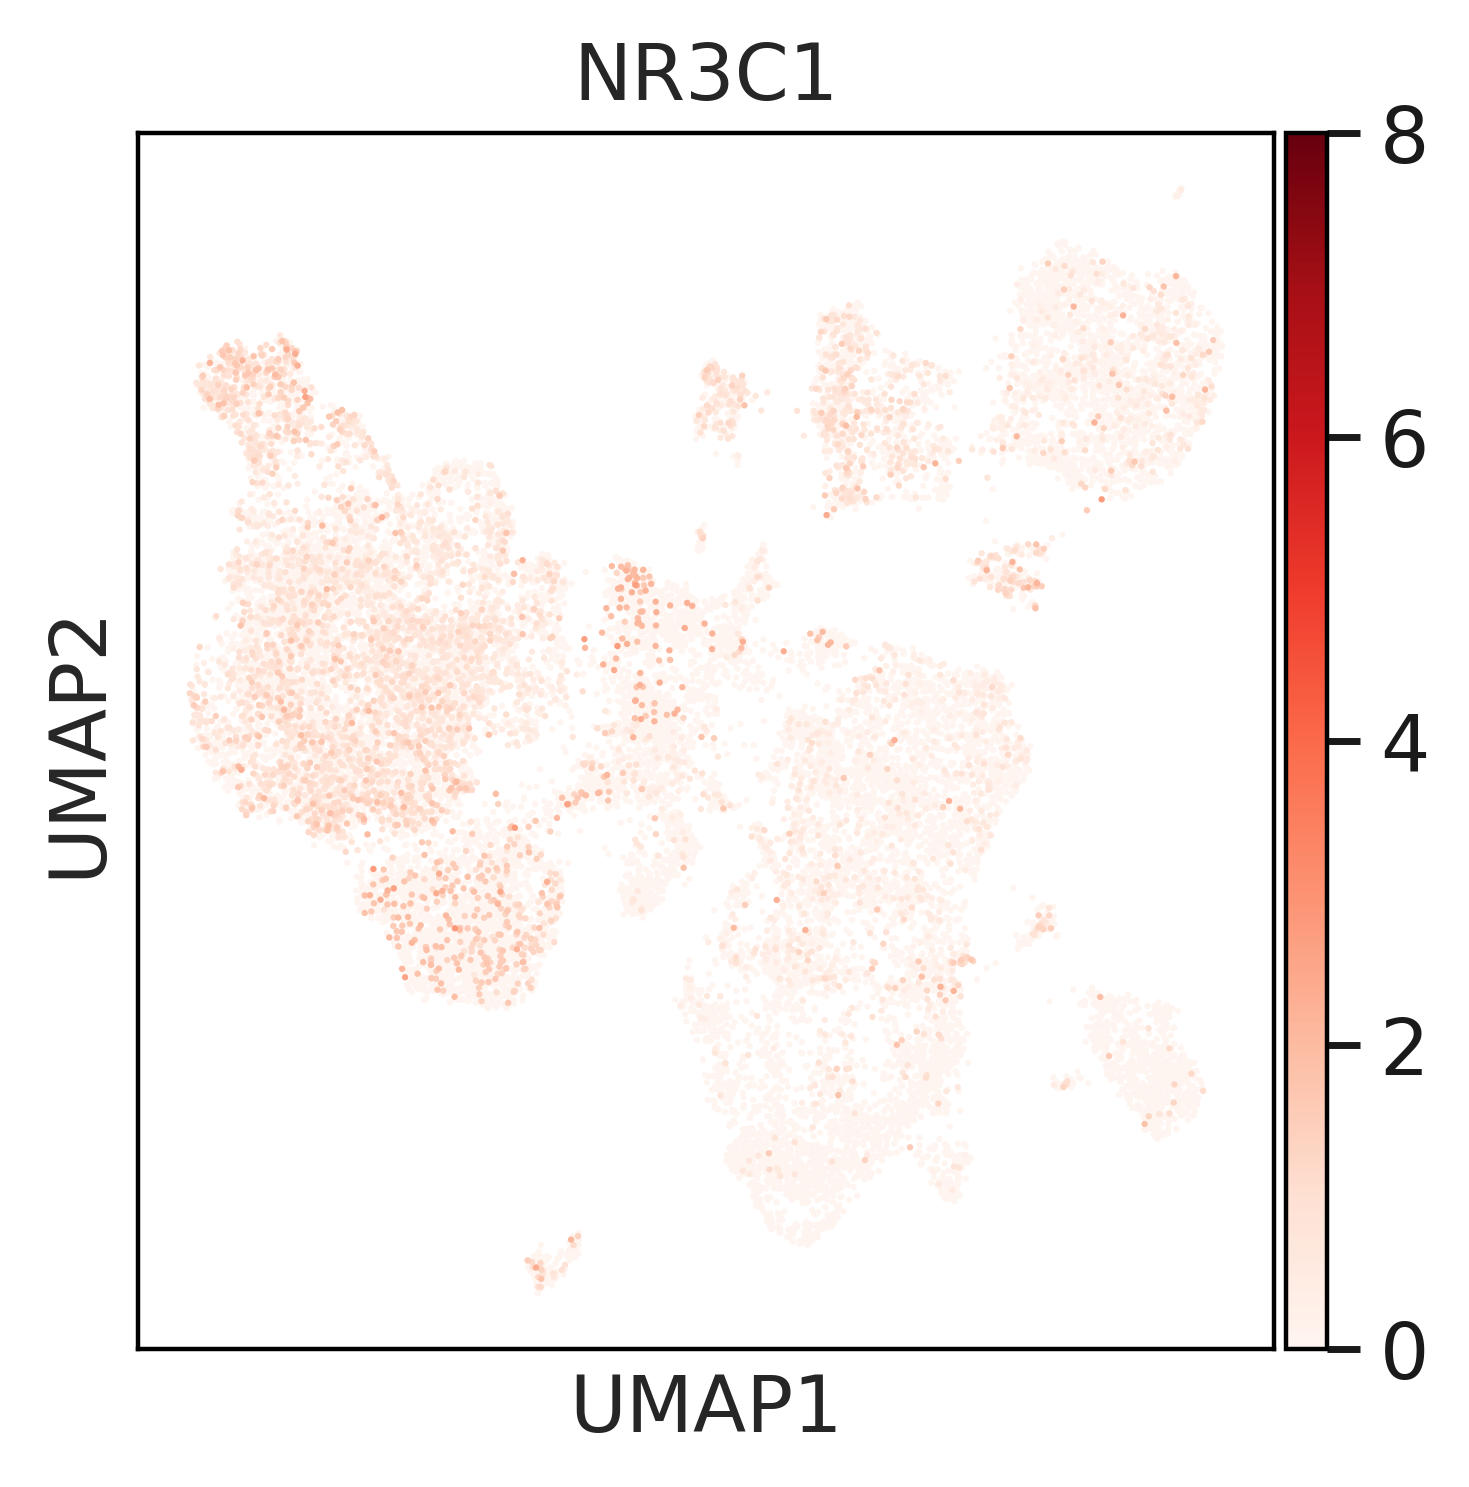

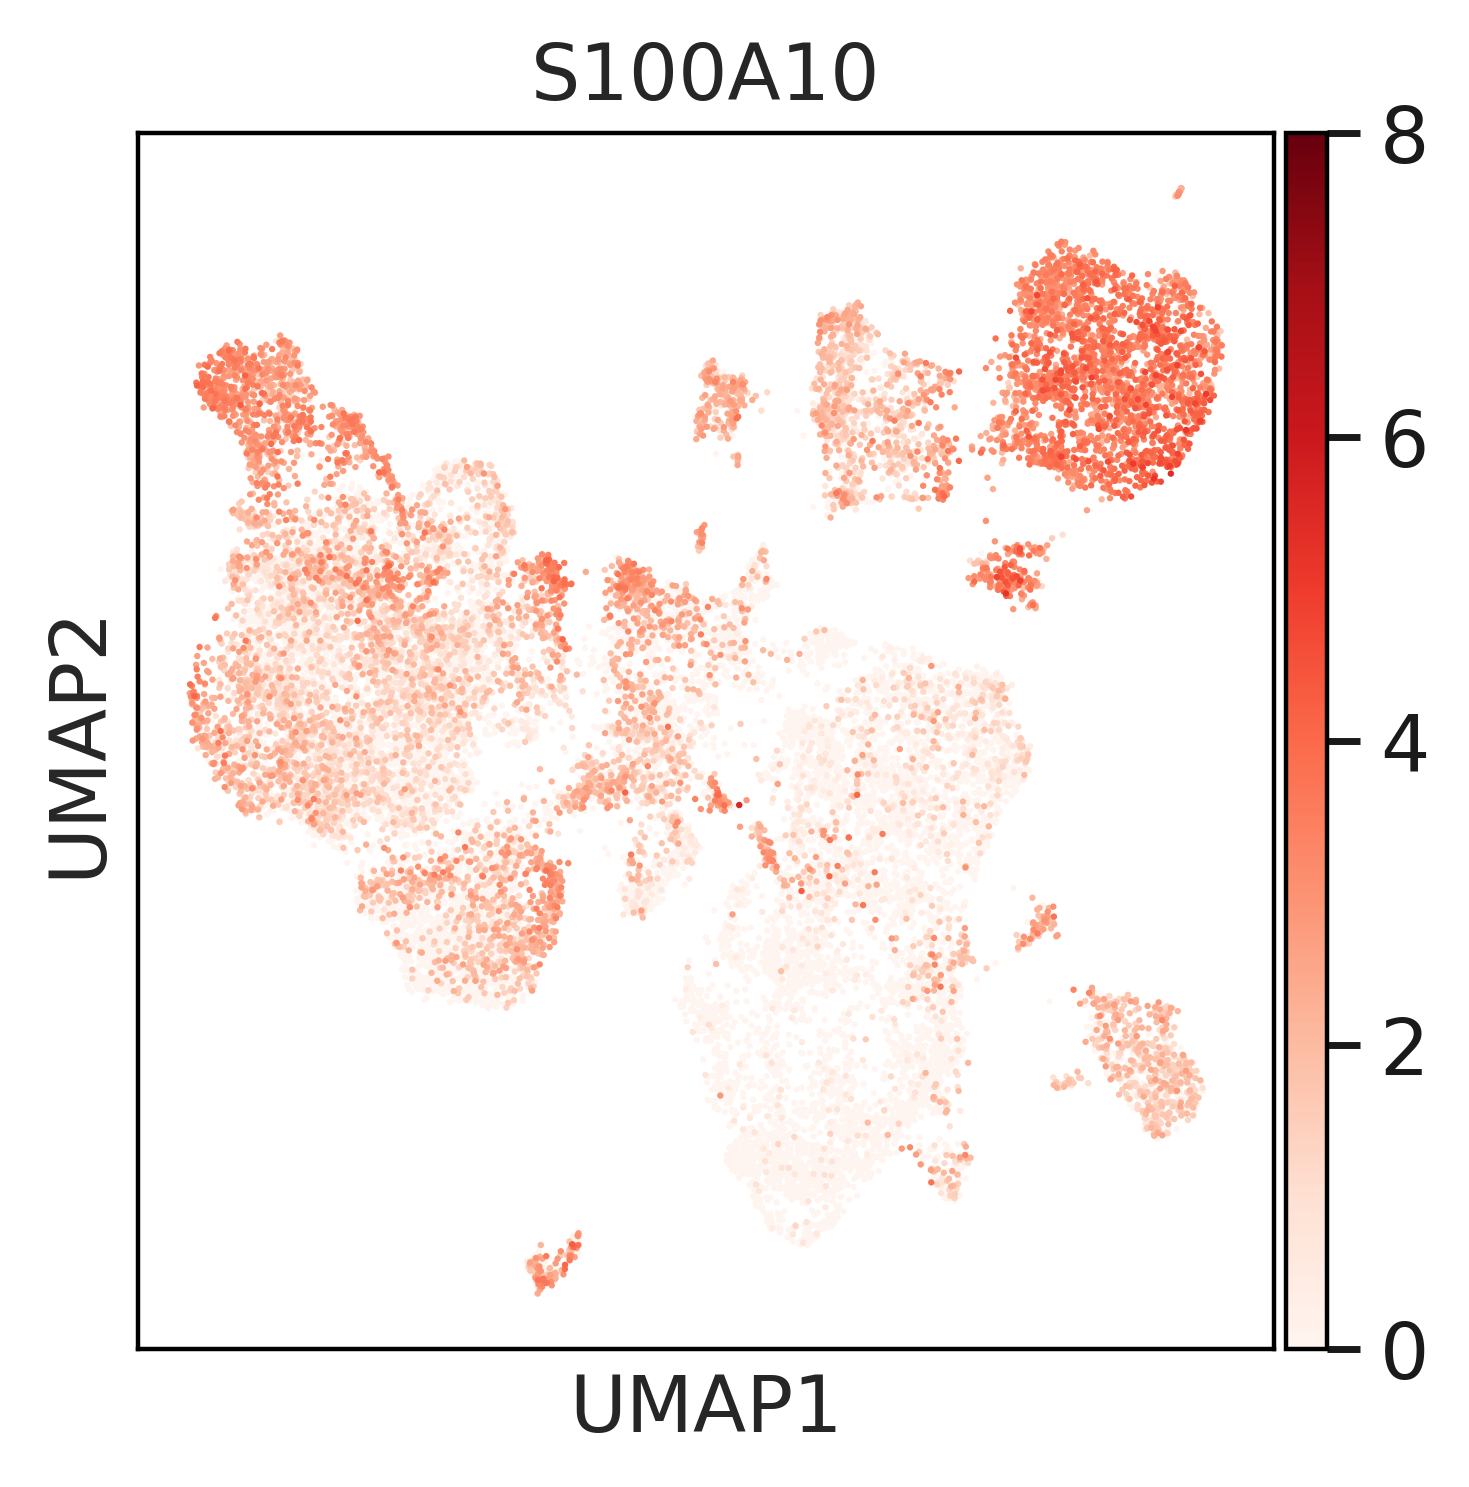

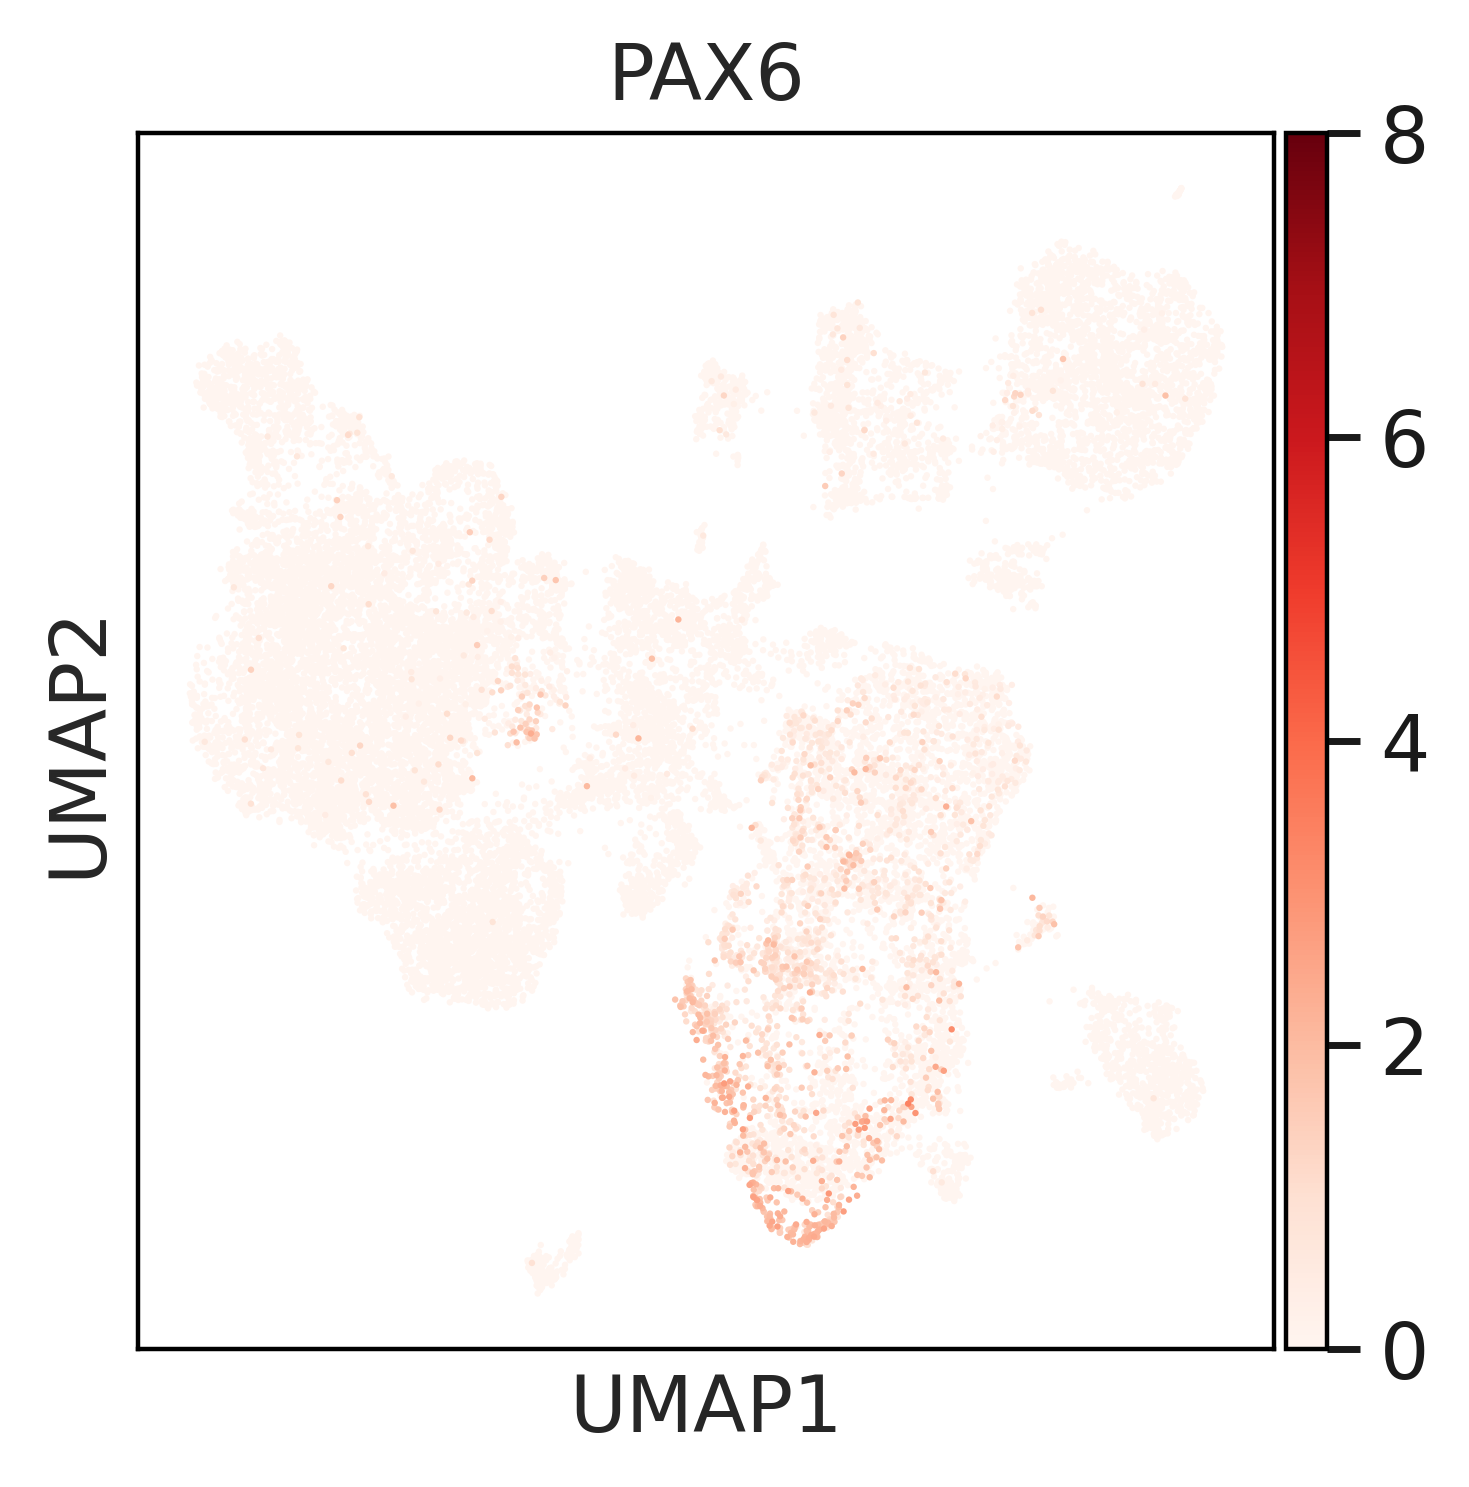

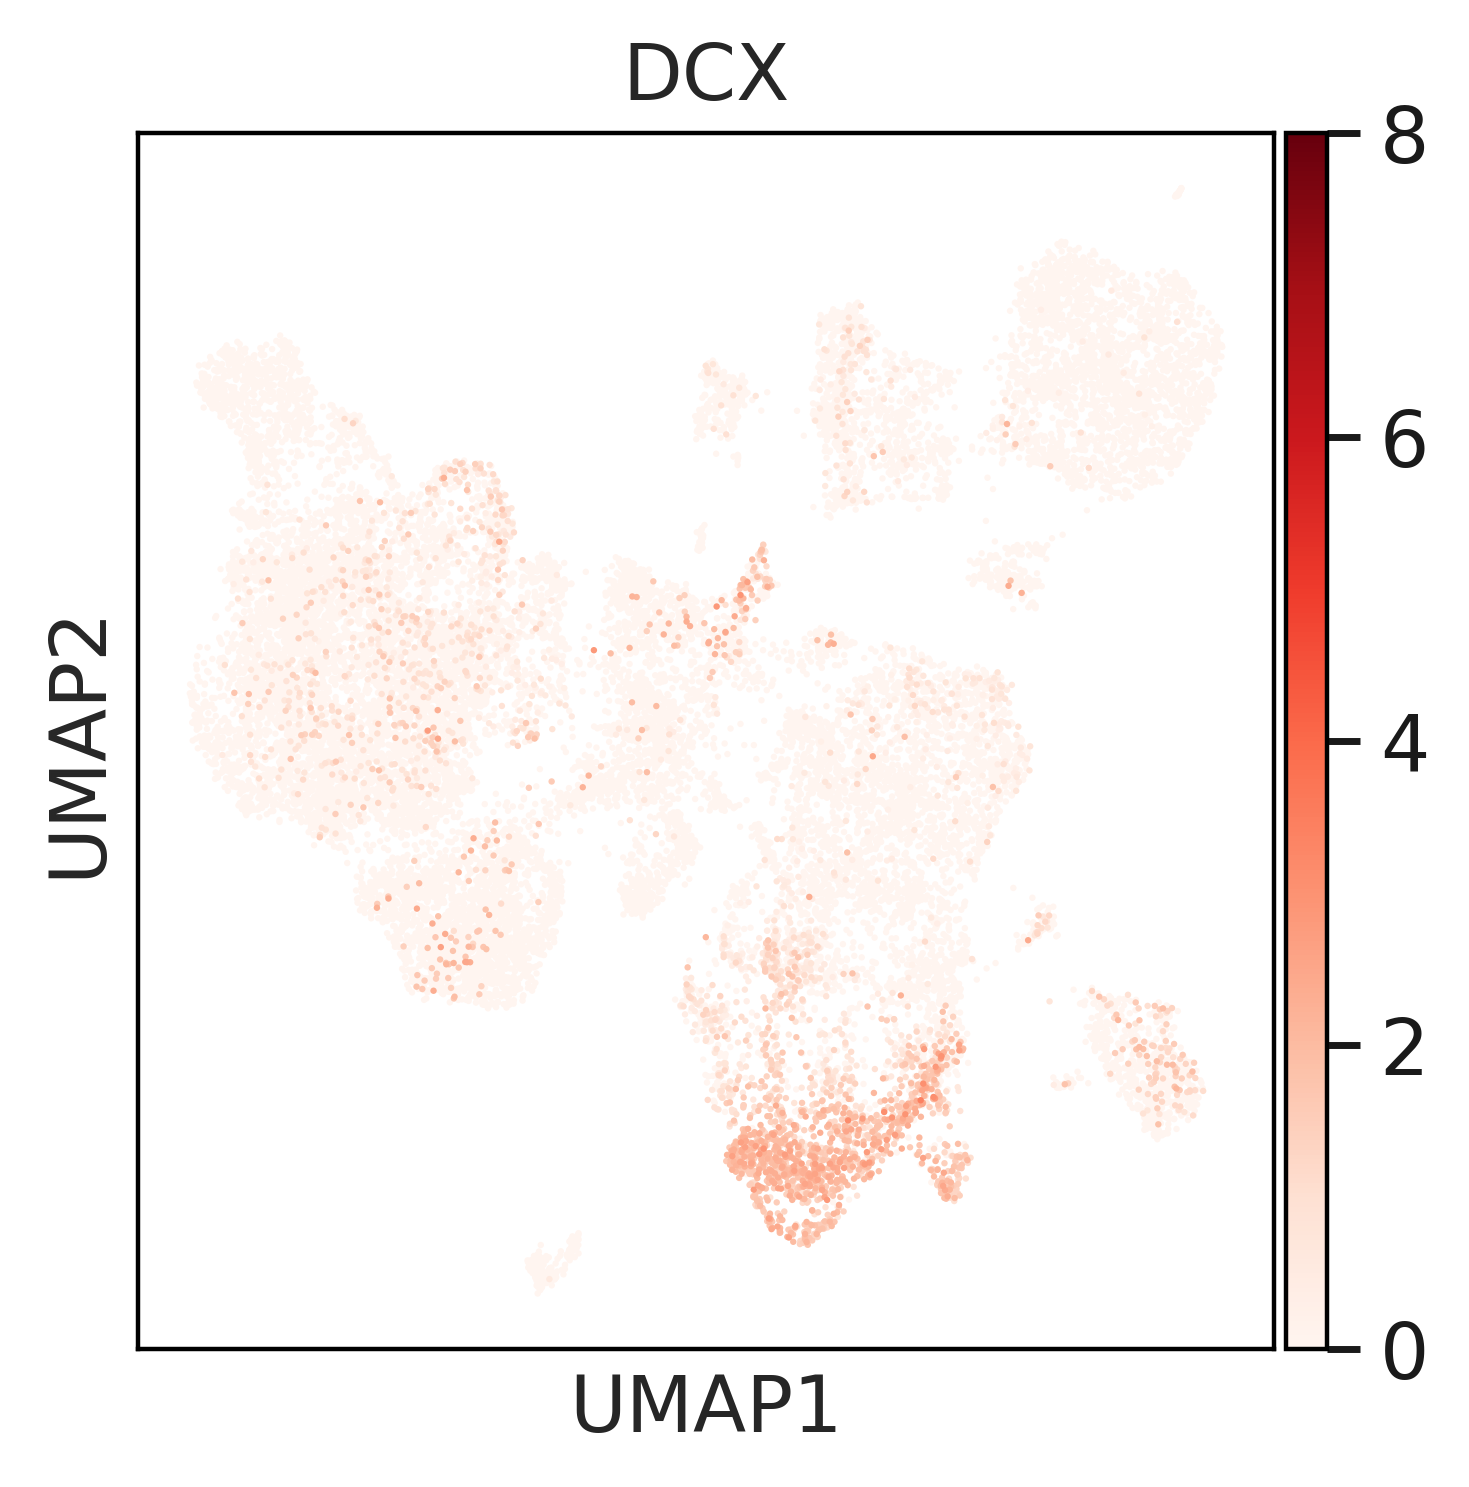

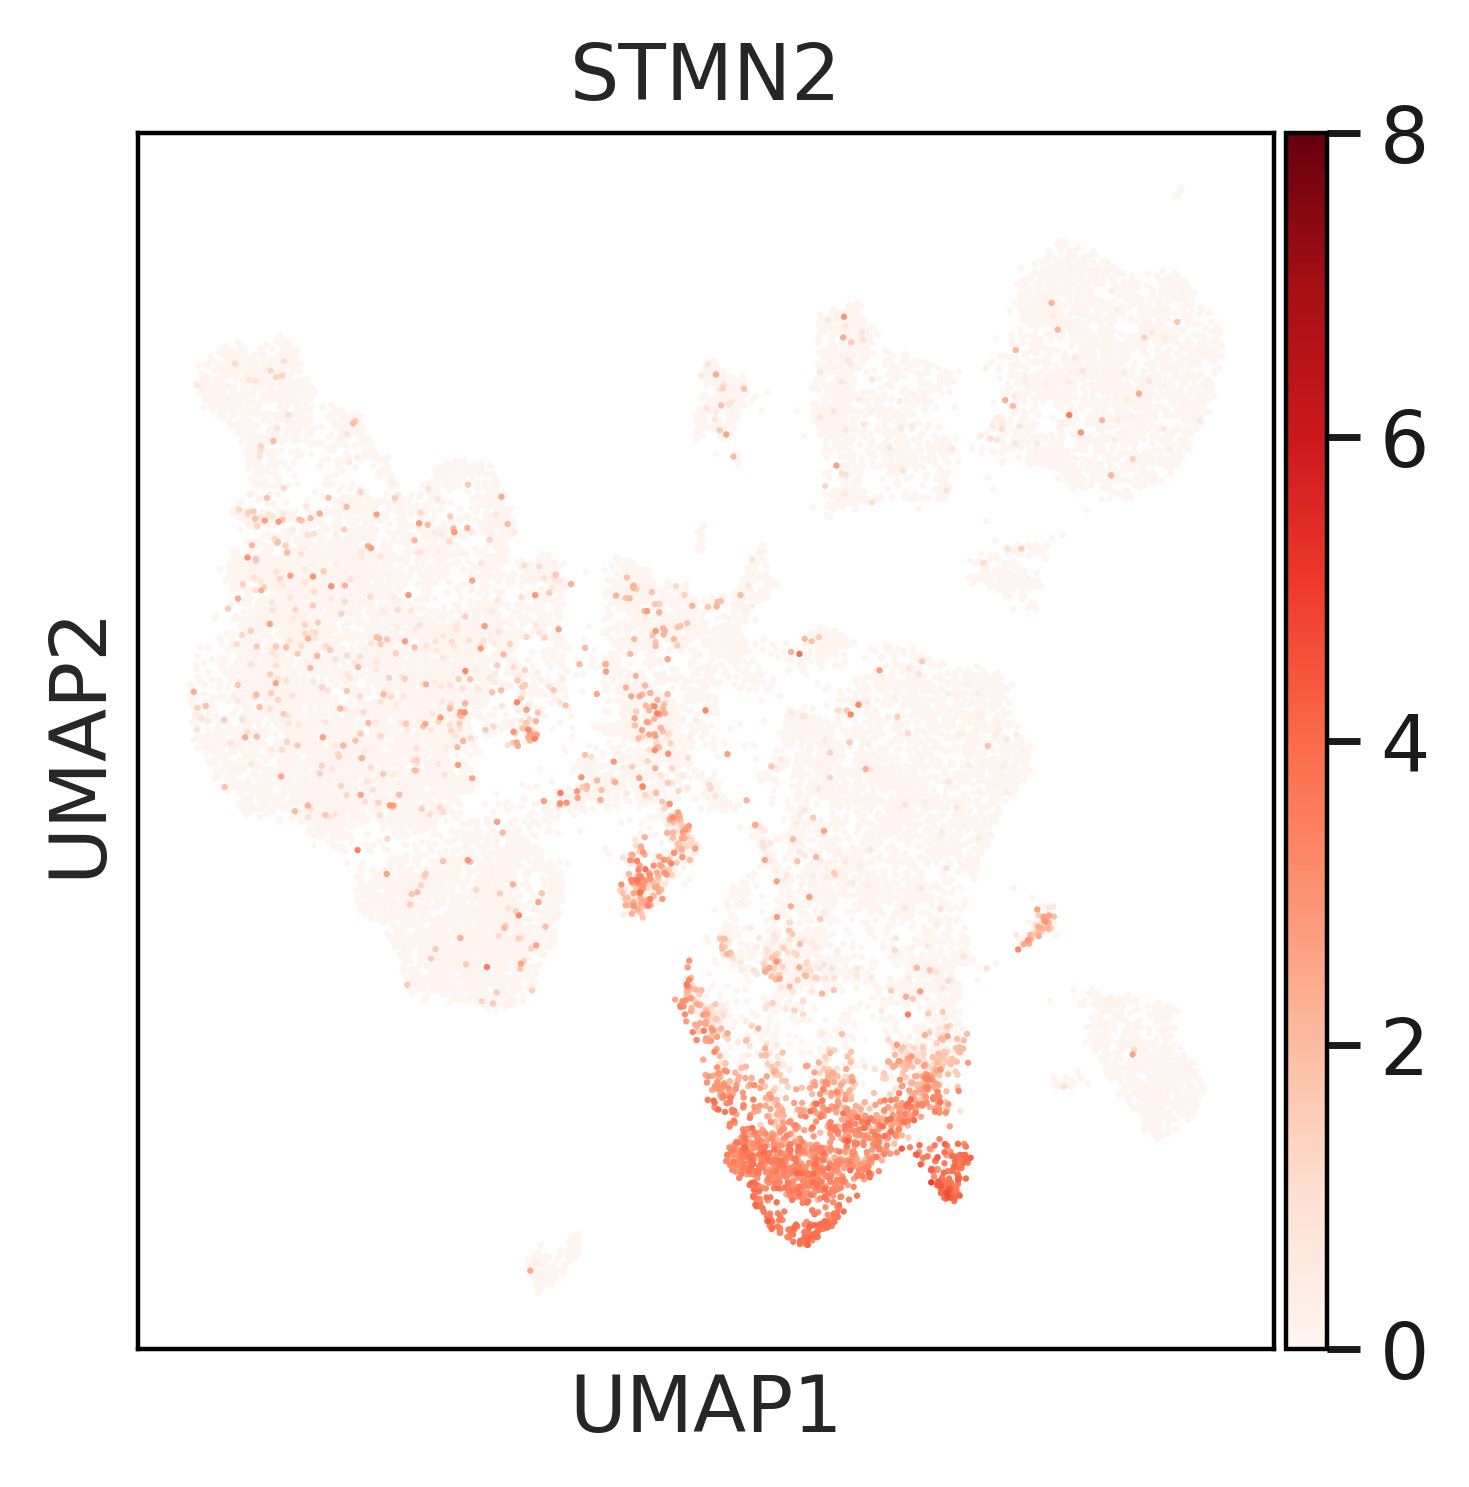

In [11]:
for g in ['NR3C1', 'S100A10', 'PAX6', 'DCX', 'STMN2']:
    sc.pl.umap(adata_fok, color=g, legend_loc='right margin', legend_fontsize=5, color_map="Reds", vmin=0, vmax=8, save=f'_fok_{g}.png')

In [43]:
# Print number of cells
for treat in ['Veh', 'Acu']:
    adata = adata_fok[adata_fok.obs['treatment'] == treat].copy()
    print(treat.upper(), 'Cells per group [FOK]')
    display(adata.obs['louvain_three'].value_counts())
    print(treat.upper(), 'NR3C1 positive Cells per group [FOK]')
    adata = adata[(adata[:,'NR3C1'].layers['counts'].A > 0)[:,0]].copy()
    display(adata.obs['louvain_three'].value_counts())

VEH Cells per group [FOK]


Non-Neural Progenitors    7341
Neural Progenitors        2968
Neurons                    578
Name: louvain_three, dtype: int64

VEH NR3C1 positive Cells per group [FOK]


Non-Neural Progenitors    1711
Neural Progenitors         487
Neurons                     14
Name: louvain_three, dtype: int64

ACU Cells per group [FOK]


Non-Neural Progenitors    7199
Neural Progenitors        3184
Neurons                   1194
Name: louvain_three, dtype: int64

ACU NR3C1 positive Cells per group [FOK]


Non-Neural Progenitors    2273
Neural Progenitors         432
Neurons                     54
Name: louvain_three, dtype: int64